In [1]:
pip install dionysus

In [0]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
import torchvision
import torchvision.transforms as T
import torchvision.datasets as dsets
import numpy as np 
import pandas as pd 
import itertools
import math
import time
import matplotlib.pyplot as plt
from __future__ import print_function
import dionysus as d
import csv
from collections import defaultdict
# import sys
# sys.path.append('../Python')
from torch.autograd import Variable, Function
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision.utils import save_image
from pprint import pprint
import os 

In [3]:
transform = T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(root='.', 
                                      train=True,
                                      download=True, 
                                      transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='.', 
                                     train=False,
                                     download=True, 
                                     transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False)

classes = [str(i) for i in range(0,10)]
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


    1     3     5     8


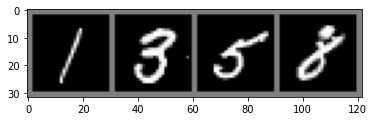

In [4]:


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out.cuda()

In [0]:
ape = (1, 28, 28)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(ape))),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *ape)
        return img

In [7]:
discriminator = Discriminator()
generator = Generator()

if torch.cuda.is_available():
    print("Using CUDA")
    discriminator.cuda()
    generator.cuda()

criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

Using CUDA


In [0]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [0]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [0]:
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100)).cuda()

In [0]:
def Generate_and_Save_Images(model, epoch, test_input):
    predictions = model(test_input).cpu()
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, : , 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


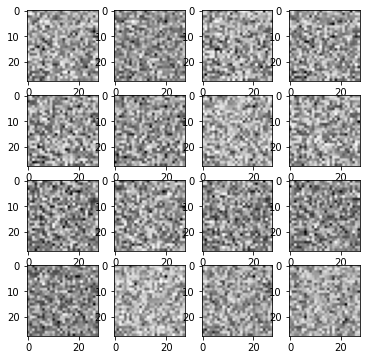

Epoch [1/50], step[1/15000], Discriminator Loss: 1.406686782836914, Generator Loss: 0.6925235986709595
Epoch [1/50], step[1001/15000], Discriminator Loss: 1.0422098636627197, Generator Loss: 0.4512685239315033
Epoch [1/50], step[2001/15000], Discriminator Loss: 0.6859206557273865, Generator Loss: 1.3732316493988037
Epoch [1/50], step[3001/15000], Discriminator Loss: 0.7627572417259216, Generator Loss: 1.0327482223510742
Epoch [1/50], step[4001/15000], Discriminator Loss: 0.6442480087280273, Generator Loss: 1.1338117122650146
Epoch [1/50], step[5001/15000], Discriminator Loss: 0.7730756998062134, Generator Loss: 0.9958702325820923
Epoch [1/50], step[6001/15000], Discriminator Loss: 0.48203805088996887, Generator Loss: 1.748094081878662
Epoch [1/50], step[7001/15000], Discriminator Loss: 0.9974820613861084, Generator Loss: 1.4540375471115112
Epoch [1/50], step[8001/15000], Discriminator Loss: 0.606002688407898, Generator Loss: 2.359647274017334
Epoch [1/50], step[9001/15000], Discriminat

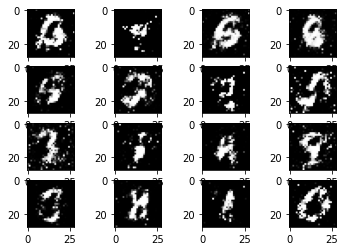

Epoch [2/50], step[1/15000], Discriminator Loss: 0.9165249466896057, Generator Loss: 1.180652379989624
Epoch [2/50], step[1001/15000], Discriminator Loss: 1.569298505783081, Generator Loss: 1.165015459060669
Epoch [2/50], step[2001/15000], Discriminator Loss: 1.218790888786316, Generator Loss: 1.2348451614379883
Epoch [2/50], step[3001/15000], Discriminator Loss: 0.6294969320297241, Generator Loss: 2.0415122509002686
Epoch [2/50], step[4001/15000], Discriminator Loss: 1.3476502895355225, Generator Loss: 1.1030213832855225
Epoch [2/50], step[5001/15000], Discriminator Loss: 1.1829016208648682, Generator Loss: 1.70100736618042
Epoch [2/50], step[6001/15000], Discriminator Loss: 0.7182765007019043, Generator Loss: 1.345117449760437
Epoch [2/50], step[7001/15000], Discriminator Loss: 0.7363221645355225, Generator Loss: 1.486445665359497
Epoch [2/50], step[8001/15000], Discriminator Loss: 0.4969422519207001, Generator Loss: 2.021172285079956
Epoch [2/50], step[9001/15000], Discriminator Los

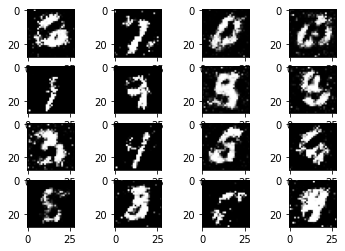

Epoch [3/50], step[1/15000], Discriminator Loss: 1.0314751863479614, Generator Loss: 1.1214014291763306
Epoch [3/50], step[1001/15000], Discriminator Loss: 0.9972137808799744, Generator Loss: 0.8642611503601074
Epoch [3/50], step[2001/15000], Discriminator Loss: 0.6647781133651733, Generator Loss: 1.5092346668243408
Epoch [3/50], step[3001/15000], Discriminator Loss: 0.7854012250900269, Generator Loss: 1.3174340724945068
Epoch [3/50], step[4001/15000], Discriminator Loss: 0.9126619100570679, Generator Loss: 1.3262414932250977
Epoch [3/50], step[5001/15000], Discriminator Loss: 1.1807934045791626, Generator Loss: 0.7444207072257996
Epoch [3/50], step[6001/15000], Discriminator Loss: 1.3618855476379395, Generator Loss: 1.0676202774047852
Epoch [3/50], step[7001/15000], Discriminator Loss: 0.9425592422485352, Generator Loss: 1.1454232931137085
Epoch [3/50], step[8001/15000], Discriminator Loss: 0.879284143447876, Generator Loss: 1.0161542892456055
Epoch [3/50], step[9001/15000], Discrimin

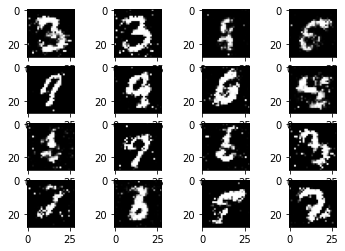

Epoch [4/50], step[1/15000], Discriminator Loss: 0.9066200256347656, Generator Loss: 0.9691797494888306
Epoch [4/50], step[1001/15000], Discriminator Loss: 1.0734392404556274, Generator Loss: 0.8677666187286377
Epoch [4/50], step[2001/15000], Discriminator Loss: 1.2596559524536133, Generator Loss: 0.9823903441429138
Epoch [4/50], step[3001/15000], Discriminator Loss: 1.3137633800506592, Generator Loss: 1.057710886001587
Epoch [4/50], step[4001/15000], Discriminator Loss: 1.066828966140747, Generator Loss: 0.8518487811088562
Epoch [4/50], step[5001/15000], Discriminator Loss: 0.85802161693573, Generator Loss: 1.1400994062423706
Epoch [4/50], step[6001/15000], Discriminator Loss: 1.1820049285888672, Generator Loss: 1.1424694061279297
Epoch [4/50], step[7001/15000], Discriminator Loss: 1.3255044221878052, Generator Loss: 0.6952567100524902
Epoch [4/50], step[8001/15000], Discriminator Loss: 1.0121688842773438, Generator Loss: 1.2718483209609985
Epoch [4/50], step[9001/15000], Discriminato

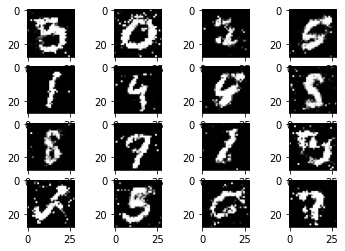

Epoch [5/50], step[1/15000], Discriminator Loss: 1.301633596420288, Generator Loss: 1.2640182971954346
Epoch [5/50], step[1001/15000], Discriminator Loss: 1.313964605331421, Generator Loss: 0.9823746681213379
Epoch [5/50], step[2001/15000], Discriminator Loss: 0.8424979448318481, Generator Loss: 0.7736172676086426
Epoch [5/50], step[3001/15000], Discriminator Loss: 0.8837060928344727, Generator Loss: 1.3076186180114746
Epoch [5/50], step[4001/15000], Discriminator Loss: 1.4635298252105713, Generator Loss: 0.9694430232048035
Epoch [5/50], step[5001/15000], Discriminator Loss: 1.2723886966705322, Generator Loss: 0.970828652381897
Epoch [5/50], step[6001/15000], Discriminator Loss: 1.5288190841674805, Generator Loss: 1.076911449432373
Epoch [5/50], step[7001/15000], Discriminator Loss: 1.0433764457702637, Generator Loss: 0.9609589576721191
Epoch [5/50], step[8001/15000], Discriminator Loss: 0.7095152735710144, Generator Loss: 0.777055025100708
Epoch [5/50], step[9001/15000], Discriminator

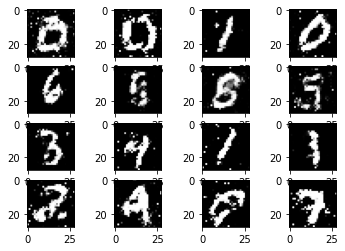

Epoch [6/50], step[1/15000], Discriminator Loss: 0.8094587326049805, Generator Loss: 0.6840580105781555
Epoch [6/50], step[1001/15000], Discriminator Loss: 1.1395678520202637, Generator Loss: 1.104050636291504
Epoch [6/50], step[2001/15000], Discriminator Loss: 1.084325909614563, Generator Loss: 1.3925725221633911
Epoch [6/50], step[3001/15000], Discriminator Loss: 0.7977533340454102, Generator Loss: 1.0703843832015991
Epoch [6/50], step[4001/15000], Discriminator Loss: 0.9980446100234985, Generator Loss: 0.8288887143135071
Epoch [6/50], step[5001/15000], Discriminator Loss: 1.0981237888336182, Generator Loss: 0.9694848656654358
Epoch [6/50], step[6001/15000], Discriminator Loss: 1.1467421054840088, Generator Loss: 0.7508677244186401
Epoch [6/50], step[7001/15000], Discriminator Loss: 1.3261137008666992, Generator Loss: 1.1246578693389893
Epoch [6/50], step[8001/15000], Discriminator Loss: 1.1574152708053589, Generator Loss: 0.7971465587615967
Epoch [6/50], step[9001/15000], Discrimina

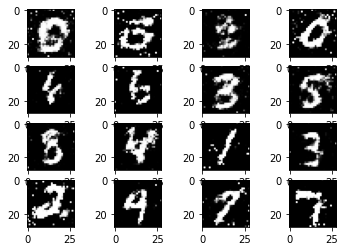

Epoch [7/50], step[1/15000], Discriminator Loss: 0.9057078957557678, Generator Loss: 0.7091262340545654
Epoch [7/50], step[1001/15000], Discriminator Loss: 1.1431585550308228, Generator Loss: 0.7401023507118225
Epoch [7/50], step[2001/15000], Discriminator Loss: 1.357290267944336, Generator Loss: 0.7087106704711914
Epoch [7/50], step[3001/15000], Discriminator Loss: 1.0532766580581665, Generator Loss: 0.944526731967926
Epoch [7/50], step[4001/15000], Discriminator Loss: 1.2527278661727905, Generator Loss: 0.7674105763435364
Epoch [7/50], step[5001/15000], Discriminator Loss: 1.449902057647705, Generator Loss: 0.9796901941299438
Epoch [7/50], step[6001/15000], Discriminator Loss: 0.9382658004760742, Generator Loss: 0.6707131862640381
Epoch [7/50], step[7001/15000], Discriminator Loss: 1.598036766052246, Generator Loss: 1.0059071779251099
Epoch [7/50], step[8001/15000], Discriminator Loss: 1.170746088027954, Generator Loss: 0.8082988262176514
Epoch [7/50], step[9001/15000], Discriminator

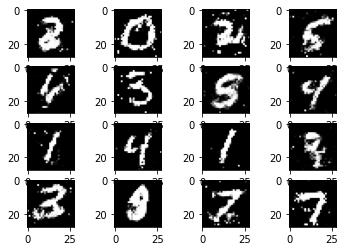

Epoch [8/50], step[1/15000], Discriminator Loss: 1.2043476104736328, Generator Loss: 0.8721157908439636
Epoch [8/50], step[1001/15000], Discriminator Loss: 1.673342227935791, Generator Loss: 0.8222756385803223
Epoch [8/50], step[2001/15000], Discriminator Loss: 1.1907942295074463, Generator Loss: 0.6733635067939758
Epoch [8/50], step[3001/15000], Discriminator Loss: 1.309008240699768, Generator Loss: 1.0063456296920776
Epoch [8/50], step[4001/15000], Discriminator Loss: 0.8328916430473328, Generator Loss: 1.2156884670257568
Epoch [8/50], step[5001/15000], Discriminator Loss: 1.2174222469329834, Generator Loss: 0.9366909265518188
Epoch [8/50], step[6001/15000], Discriminator Loss: 1.1013288497924805, Generator Loss: 0.8296692967414856
Epoch [8/50], step[7001/15000], Discriminator Loss: 0.9156463146209717, Generator Loss: 0.7941254377365112
Epoch [8/50], step[8001/15000], Discriminator Loss: 1.3785134553909302, Generator Loss: 0.7986752390861511
Epoch [8/50], step[9001/15000], Discrimina

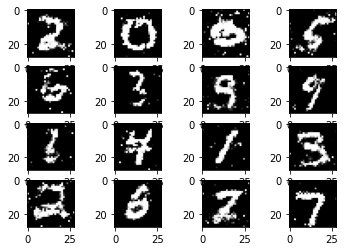

Epoch [9/50], step[1/15000], Discriminator Loss: 1.0757725238800049, Generator Loss: 1.4163554906845093
Epoch [9/50], step[1001/15000], Discriminator Loss: 1.5303065776824951, Generator Loss: 1.0942678451538086
Epoch [9/50], step[2001/15000], Discriminator Loss: 1.4463365077972412, Generator Loss: 0.9226722717285156
Epoch [9/50], step[3001/15000], Discriminator Loss: 1.6450268030166626, Generator Loss: 0.9137067198753357
Epoch [9/50], step[4001/15000], Discriminator Loss: 1.2858190536499023, Generator Loss: 0.7282217144966125
Epoch [9/50], step[5001/15000], Discriminator Loss: 1.1468621492385864, Generator Loss: 0.6273466348648071
Epoch [9/50], step[6001/15000], Discriminator Loss: 1.244439959526062, Generator Loss: 0.5180467367172241
Epoch [9/50], step[7001/15000], Discriminator Loss: 1.3668931722640991, Generator Loss: 1.0344388484954834
Epoch [9/50], step[8001/15000], Discriminator Loss: 1.3614513874053955, Generator Loss: 0.9028869867324829
Epoch [9/50], step[9001/15000], Discrimin

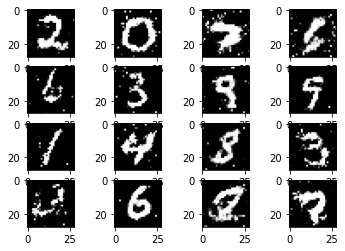

Epoch [10/50], step[1/15000], Discriminator Loss: 1.073981523513794, Generator Loss: 0.7595135569572449
Epoch [10/50], step[1001/15000], Discriminator Loss: 0.8324352502822876, Generator Loss: 1.1930572986602783
Epoch [10/50], step[2001/15000], Discriminator Loss: 1.169597864151001, Generator Loss: 0.8856923580169678
Epoch [10/50], step[3001/15000], Discriminator Loss: 1.4510412216186523, Generator Loss: 0.7084271907806396
Epoch [10/50], step[4001/15000], Discriminator Loss: 1.4114320278167725, Generator Loss: 0.7793474197387695
Epoch [10/50], step[5001/15000], Discriminator Loss: 1.436010479927063, Generator Loss: 0.9500571489334106
Epoch [10/50], step[6001/15000], Discriminator Loss: 1.115682601928711, Generator Loss: 0.9266422390937805
Epoch [10/50], step[7001/15000], Discriminator Loss: 1.0061540603637695, Generator Loss: 0.7249059677124023
Epoch [10/50], step[8001/15000], Discriminator Loss: 1.0212736129760742, Generator Loss: 1.0251041650772095
Epoch [10/50], step[9001/15000], Di

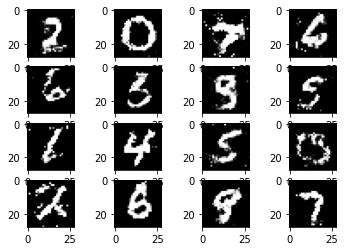

Epoch [11/50], step[1/15000], Discriminator Loss: 1.239668369293213, Generator Loss: 0.979208767414093
Epoch [11/50], step[1001/15000], Discriminator Loss: 1.0151188373565674, Generator Loss: 0.7692313194274902
Epoch [11/50], step[2001/15000], Discriminator Loss: 1.3068963289260864, Generator Loss: 1.1076385974884033
Epoch [11/50], step[3001/15000], Discriminator Loss: 1.641904592514038, Generator Loss: 0.8454011678695679
Epoch [11/50], step[4001/15000], Discriminator Loss: 1.488610863685608, Generator Loss: 0.8843957185745239
Epoch [11/50], step[5001/15000], Discriminator Loss: 1.3522175550460815, Generator Loss: 0.7518466711044312
Epoch [11/50], step[6001/15000], Discriminator Loss: 1.19807767868042, Generator Loss: 0.7920899391174316
Epoch [11/50], step[7001/15000], Discriminator Loss: 1.0844337940216064, Generator Loss: 0.8383572101593018
Epoch [11/50], step[8001/15000], Discriminator Loss: 1.5320254564285278, Generator Loss: 1.0046048164367676
Epoch [11/50], step[9001/15000], Disc

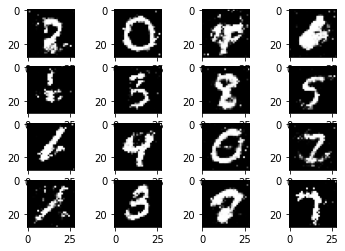

Epoch [12/50], step[1/15000], Discriminator Loss: 1.0302581787109375, Generator Loss: 0.7319989204406738
Epoch [12/50], step[1001/15000], Discriminator Loss: 1.1592572927474976, Generator Loss: 1.3558722734451294
Epoch [12/50], step[2001/15000], Discriminator Loss: 1.2667778730392456, Generator Loss: 0.602733850479126
Epoch [12/50], step[3001/15000], Discriminator Loss: 1.1140414476394653, Generator Loss: 0.8943809270858765
Epoch [12/50], step[4001/15000], Discriminator Loss: 1.0821099281311035, Generator Loss: 0.9211230874061584
Epoch [12/50], step[5001/15000], Discriminator Loss: 1.3913052082061768, Generator Loss: 0.7203489542007446
Epoch [12/50], step[6001/15000], Discriminator Loss: 1.2998981475830078, Generator Loss: 1.2323806285858154
Epoch [12/50], step[7001/15000], Discriminator Loss: 1.4156314134597778, Generator Loss: 0.6742933392524719
Epoch [12/50], step[8001/15000], Discriminator Loss: 1.377570390701294, Generator Loss: 0.9151096940040588
Epoch [12/50], step[9001/15000], 

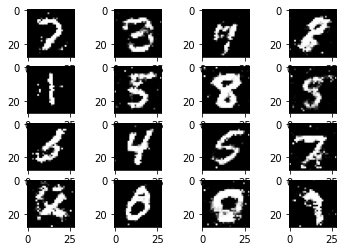

Epoch [13/50], step[1/15000], Discriminator Loss: 0.8509032726287842, Generator Loss: 0.9181737899780273
Epoch [13/50], step[1001/15000], Discriminator Loss: 1.2876484394073486, Generator Loss: 1.0932793617248535
Epoch [13/50], step[2001/15000], Discriminator Loss: 1.2144722938537598, Generator Loss: 0.6452919840812683
Epoch [13/50], step[3001/15000], Discriminator Loss: 1.050025224685669, Generator Loss: 0.7540441751480103
Epoch [13/50], step[4001/15000], Discriminator Loss: 1.1125788688659668, Generator Loss: 1.035137414932251
Epoch [13/50], step[5001/15000], Discriminator Loss: 1.4769108295440674, Generator Loss: 0.9392186999320984
Epoch [13/50], step[6001/15000], Discriminator Loss: 1.2866075038909912, Generator Loss: 0.969559371471405
Epoch [13/50], step[7001/15000], Discriminator Loss: 1.0597535371780396, Generator Loss: 1.0095802545547485
Epoch [13/50], step[8001/15000], Discriminator Loss: 1.4483754634857178, Generator Loss: 0.7827664017677307
Epoch [13/50], step[9001/15000], D

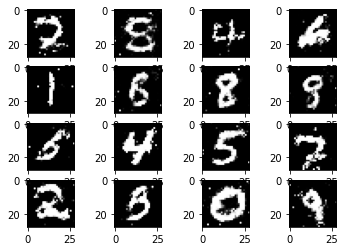

Epoch [14/50], step[1/15000], Discriminator Loss: 1.4368860721588135, Generator Loss: 0.976573646068573
Epoch [14/50], step[1001/15000], Discriminator Loss: 0.9263706207275391, Generator Loss: 0.8659777641296387
Epoch [14/50], step[2001/15000], Discriminator Loss: 1.1033743619918823, Generator Loss: 1.0015050172805786
Epoch [14/50], step[3001/15000], Discriminator Loss: 1.2371718883514404, Generator Loss: 0.8840816020965576
Epoch [14/50], step[4001/15000], Discriminator Loss: 0.8791515231132507, Generator Loss: 0.8885455131530762
Epoch [14/50], step[5001/15000], Discriminator Loss: 1.5282468795776367, Generator Loss: 0.7921423316001892
Epoch [14/50], step[6001/15000], Discriminator Loss: 1.3049086332321167, Generator Loss: 0.9206487536430359
Epoch [14/50], step[7001/15000], Discriminator Loss: 1.6294087171554565, Generator Loss: 0.697161078453064
Epoch [14/50], step[8001/15000], Discriminator Loss: 1.3657323122024536, Generator Loss: 1.0391731262207031
Epoch [14/50], step[9001/15000], 

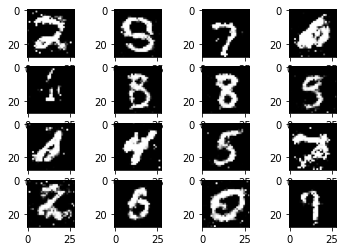

Epoch [15/50], step[1/15000], Discriminator Loss: 1.2963440418243408, Generator Loss: 0.9065115451812744
Epoch [15/50], step[1001/15000], Discriminator Loss: 1.492462396621704, Generator Loss: 1.024648904800415
Epoch [15/50], step[2001/15000], Discriminator Loss: 1.6477065086364746, Generator Loss: 0.8105167150497437
Epoch [15/50], step[3001/15000], Discriminator Loss: 1.5183796882629395, Generator Loss: 0.9336251020431519
Epoch [15/50], step[4001/15000], Discriminator Loss: 1.346734881401062, Generator Loss: 1.0525959730148315
Epoch [15/50], step[5001/15000], Discriminator Loss: 1.2582021951675415, Generator Loss: 0.7636901140213013
Epoch [15/50], step[6001/15000], Discriminator Loss: 1.3846800327301025, Generator Loss: 0.7604931592941284
Epoch [15/50], step[7001/15000], Discriminator Loss: 1.4793314933776855, Generator Loss: 0.8263939023017883
Epoch [15/50], step[8001/15000], Discriminator Loss: 1.262341022491455, Generator Loss: 1.1598575115203857
Epoch [15/50], step[9001/15000], Di

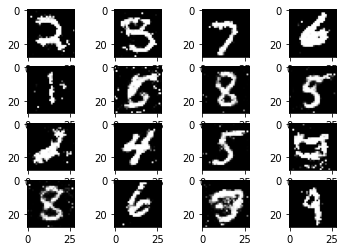

Epoch [16/50], step[1/15000], Discriminator Loss: 1.6926785707473755, Generator Loss: 1.0776786804199219
Epoch [16/50], step[1001/15000], Discriminator Loss: 1.1070137023925781, Generator Loss: 0.7819336652755737
Epoch [16/50], step[2001/15000], Discriminator Loss: 1.2792184352874756, Generator Loss: 0.6946747899055481
Epoch [16/50], step[3001/15000], Discriminator Loss: 1.4115338325500488, Generator Loss: 0.6219853758811951
Epoch [16/50], step[4001/15000], Discriminator Loss: 1.184905767440796, Generator Loss: 0.6225902438163757
Epoch [16/50], step[5001/15000], Discriminator Loss: 1.3880704641342163, Generator Loss: 0.6013072729110718
Epoch [16/50], step[6001/15000], Discriminator Loss: 1.6399939060211182, Generator Loss: 0.8973865509033203
Epoch [16/50], step[7001/15000], Discriminator Loss: 0.954883337020874, Generator Loss: 0.6676046848297119
Epoch [16/50], step[8001/15000], Discriminator Loss: 1.135871410369873, Generator Loss: 0.945707380771637
Epoch [16/50], step[9001/15000], Di

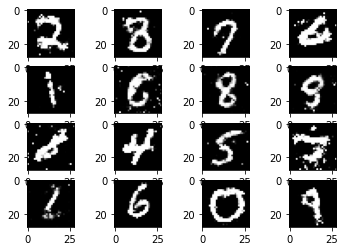

Epoch [17/50], step[1/15000], Discriminator Loss: 1.2857985496520996, Generator Loss: 0.8095954656600952
Epoch [17/50], step[1001/15000], Discriminator Loss: 1.9326627254486084, Generator Loss: 0.9376147985458374
Epoch [17/50], step[2001/15000], Discriminator Loss: 1.370969533920288, Generator Loss: 0.9031226634979248
Epoch [17/50], step[3001/15000], Discriminator Loss: 1.4374473094940186, Generator Loss: 1.04121994972229
Epoch [17/50], step[4001/15000], Discriminator Loss: 1.1514372825622559, Generator Loss: 0.7816268801689148
Epoch [17/50], step[5001/15000], Discriminator Loss: 1.2522921562194824, Generator Loss: 0.7352151870727539
Epoch [17/50], step[6001/15000], Discriminator Loss: 1.0635493993759155, Generator Loss: 0.8918932676315308
Epoch [17/50], step[7001/15000], Discriminator Loss: 1.1728655099868774, Generator Loss: 0.970481276512146
Epoch [17/50], step[8001/15000], Discriminator Loss: 1.142061471939087, Generator Loss: 0.8761031627655029
Epoch [17/50], step[9001/15000], Dis

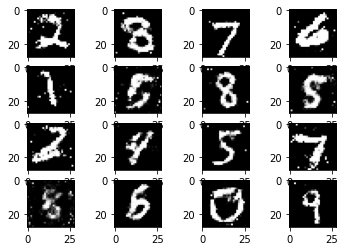

Epoch [18/50], step[1/15000], Discriminator Loss: 1.1091563701629639, Generator Loss: 0.7563579082489014
Epoch [18/50], step[1001/15000], Discriminator Loss: 1.2918951511383057, Generator Loss: 0.9014332890510559
Epoch [18/50], step[2001/15000], Discriminator Loss: 1.8055013418197632, Generator Loss: 0.8196014165878296
Epoch [18/50], step[3001/15000], Discriminator Loss: 1.3574696779251099, Generator Loss: 0.8434706926345825
Epoch [18/50], step[4001/15000], Discriminator Loss: 1.2541859149932861, Generator Loss: 0.6814930438995361
Epoch [18/50], step[5001/15000], Discriminator Loss: 1.6729857921600342, Generator Loss: 0.8435608148574829
Epoch [18/50], step[6001/15000], Discriminator Loss: 0.951345682144165, Generator Loss: 1.0671006441116333
Epoch [18/50], step[7001/15000], Discriminator Loss: 1.5306377410888672, Generator Loss: 0.7122219800949097
Epoch [18/50], step[8001/15000], Discriminator Loss: 1.3828283548355103, Generator Loss: 0.9232298135757446
Epoch [18/50], step[9001/15000],

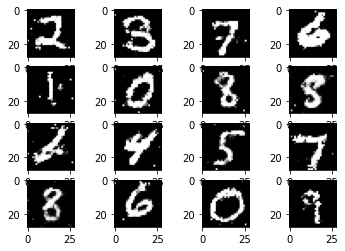

Epoch [19/50], step[1/15000], Discriminator Loss: 1.0434342622756958, Generator Loss: 0.8095950484275818
Epoch [19/50], step[1001/15000], Discriminator Loss: 1.474517583847046, Generator Loss: 0.7571130990982056
Epoch [19/50], step[2001/15000], Discriminator Loss: 1.3211249113082886, Generator Loss: 0.6404597163200378
Epoch [19/50], step[3001/15000], Discriminator Loss: 1.2239856719970703, Generator Loss: 0.8170498609542847
Epoch [19/50], step[4001/15000], Discriminator Loss: 1.2468374967575073, Generator Loss: 0.5628735423088074
Epoch [19/50], step[5001/15000], Discriminator Loss: 1.2713940143585205, Generator Loss: 0.8362645506858826
Epoch [19/50], step[6001/15000], Discriminator Loss: 1.2427372932434082, Generator Loss: 1.0231846570968628
Epoch [19/50], step[7001/15000], Discriminator Loss: 1.3232402801513672, Generator Loss: 0.8109216690063477
Epoch [19/50], step[8001/15000], Discriminator Loss: 1.1706984043121338, Generator Loss: 0.4757706820964813
Epoch [19/50], step[9001/15000],

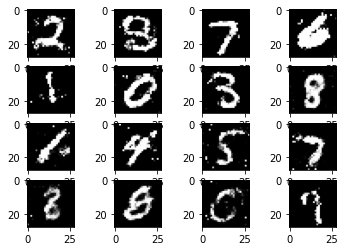

Epoch [20/50], step[1/15000], Discriminator Loss: 1.4751125574111938, Generator Loss: 1.049921989440918
Epoch [20/50], step[1001/15000], Discriminator Loss: 1.939992904663086, Generator Loss: 0.8698940873146057
Epoch [20/50], step[2001/15000], Discriminator Loss: 1.2805571556091309, Generator Loss: 0.6979048252105713
Epoch [20/50], step[3001/15000], Discriminator Loss: 1.4220519065856934, Generator Loss: 0.8941315412521362
Epoch [20/50], step[4001/15000], Discriminator Loss: 1.6116607189178467, Generator Loss: 0.8260318040847778
Epoch [20/50], step[5001/15000], Discriminator Loss: 1.3672504425048828, Generator Loss: 0.4602045714855194
Epoch [20/50], step[6001/15000], Discriminator Loss: 1.553922414779663, Generator Loss: 0.8923587799072266
Epoch [20/50], step[7001/15000], Discriminator Loss: 1.1776810884475708, Generator Loss: 0.9980246424674988
Epoch [20/50], step[8001/15000], Discriminator Loss: 1.3296551704406738, Generator Loss: 0.7192122936248779
Epoch [20/50], step[9001/15000], D

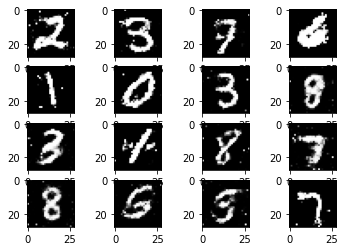

Epoch [21/50], step[1/15000], Discriminator Loss: 1.0663981437683105, Generator Loss: 1.1463712453842163
Epoch [21/50], step[1001/15000], Discriminator Loss: 1.3437715768814087, Generator Loss: 1.027053952217102
Epoch [21/50], step[2001/15000], Discriminator Loss: 1.281596064567566, Generator Loss: 0.8126615881919861
Epoch [21/50], step[3001/15000], Discriminator Loss: 1.4865323305130005, Generator Loss: 0.7907475829124451
Epoch [21/50], step[4001/15000], Discriminator Loss: 1.1460349559783936, Generator Loss: 0.8918612003326416
Epoch [21/50], step[5001/15000], Discriminator Loss: 1.4643151760101318, Generator Loss: 1.0044758319854736
Epoch [21/50], step[6001/15000], Discriminator Loss: 1.249886155128479, Generator Loss: 1.0559077262878418
Epoch [21/50], step[7001/15000], Discriminator Loss: 1.0752873420715332, Generator Loss: 0.6941508054733276
Epoch [21/50], step[8001/15000], Discriminator Loss: 1.6314494609832764, Generator Loss: 0.9258280396461487
Epoch [21/50], step[9001/15000], D

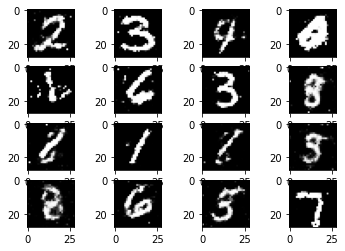

Epoch [22/50], step[1/15000], Discriminator Loss: 1.3652281761169434, Generator Loss: 0.8984692096710205
Epoch [22/50], step[1001/15000], Discriminator Loss: 1.257332682609558, Generator Loss: 0.9384907484054565
Epoch [22/50], step[2001/15000], Discriminator Loss: 1.3363454341888428, Generator Loss: 0.8447093963623047
Epoch [22/50], step[3001/15000], Discriminator Loss: 1.284209966659546, Generator Loss: 0.911202073097229
Epoch [22/50], step[4001/15000], Discriminator Loss: 1.4503991603851318, Generator Loss: 0.7879801988601685
Epoch [22/50], step[5001/15000], Discriminator Loss: 1.480647325515747, Generator Loss: 0.9560229778289795
Epoch [22/50], step[6001/15000], Discriminator Loss: 1.3738023042678833, Generator Loss: 0.8308987021446228
Epoch [22/50], step[7001/15000], Discriminator Loss: 1.3311011791229248, Generator Loss: 0.8598376512527466
Epoch [22/50], step[8001/15000], Discriminator Loss: 1.4042065143585205, Generator Loss: 0.6428092122077942
Epoch [22/50], step[9001/15000], Di

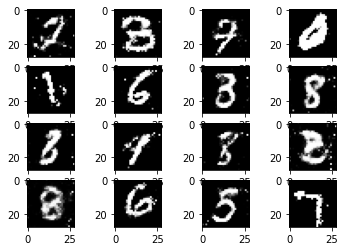

Epoch [23/50], step[1/15000], Discriminator Loss: 1.343418002128601, Generator Loss: 0.9682576060295105
Epoch [23/50], step[1001/15000], Discriminator Loss: 1.2804203033447266, Generator Loss: 0.7238506078720093
Epoch [23/50], step[2001/15000], Discriminator Loss: 1.2639384269714355, Generator Loss: 0.8800601959228516
Epoch [23/50], step[3001/15000], Discriminator Loss: 1.0210144519805908, Generator Loss: 0.8410816192626953
Epoch [23/50], step[4001/15000], Discriminator Loss: 1.1280593872070312, Generator Loss: 0.8422785997390747
Epoch [23/50], step[5001/15000], Discriminator Loss: 0.8442456722259521, Generator Loss: 0.9884281158447266
Epoch [23/50], step[6001/15000], Discriminator Loss: 1.206346035003662, Generator Loss: 0.7029659152030945
Epoch [23/50], step[7001/15000], Discriminator Loss: 1.162931203842163, Generator Loss: 0.828038215637207
Epoch [23/50], step[8001/15000], Discriminator Loss: 1.1834572553634644, Generator Loss: 0.7054998874664307
Epoch [23/50], step[9001/15000], Di

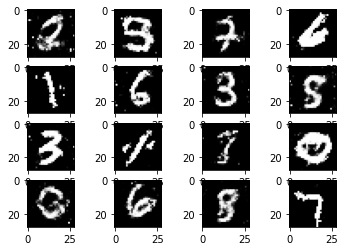

Epoch [24/50], step[1/15000], Discriminator Loss: 1.3261208534240723, Generator Loss: 0.7015111446380615
Epoch [24/50], step[1001/15000], Discriminator Loss: 1.4876258373260498, Generator Loss: 0.5292221307754517
Epoch [24/50], step[2001/15000], Discriminator Loss: 1.2143447399139404, Generator Loss: 0.7448054552078247
Epoch [24/50], step[3001/15000], Discriminator Loss: 0.9527722597122192, Generator Loss: 0.9562498331069946
Epoch [24/50], step[4001/15000], Discriminator Loss: 1.2806388139724731, Generator Loss: 0.5167135000228882
Epoch [24/50], step[5001/15000], Discriminator Loss: 1.3691866397857666, Generator Loss: 0.7075541019439697
Epoch [24/50], step[6001/15000], Discriminator Loss: 1.210599422454834, Generator Loss: 0.6869575381278992
Epoch [24/50], step[7001/15000], Discriminator Loss: 1.3301606178283691, Generator Loss: 0.8955779075622559
Epoch [24/50], step[8001/15000], Discriminator Loss: 1.0864983797073364, Generator Loss: 0.6457536816596985
Epoch [24/50], step[9001/15000],

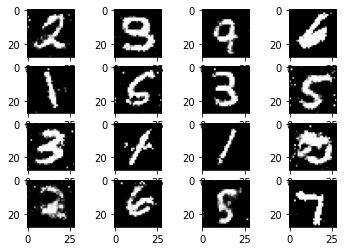

Epoch [25/50], step[1/15000], Discriminator Loss: 1.1551074981689453, Generator Loss: 0.8326236009597778
Epoch [25/50], step[1001/15000], Discriminator Loss: 1.6512330770492554, Generator Loss: 0.8734302520751953
Epoch [25/50], step[2001/15000], Discriminator Loss: 1.1493561267852783, Generator Loss: 0.8298251032829285
Epoch [25/50], step[3001/15000], Discriminator Loss: 1.4362082481384277, Generator Loss: 1.0395629405975342
Epoch [25/50], step[4001/15000], Discriminator Loss: 1.2614526748657227, Generator Loss: 0.723342776298523
Epoch [25/50], step[5001/15000], Discriminator Loss: 1.3846945762634277, Generator Loss: 0.8615962266921997
Epoch [25/50], step[6001/15000], Discriminator Loss: 1.2396745681762695, Generator Loss: 1.0427665710449219
Epoch [25/50], step[7001/15000], Discriminator Loss: 1.319495439529419, Generator Loss: 1.0190978050231934
Epoch [25/50], step[8001/15000], Discriminator Loss: 0.9196024537086487, Generator Loss: 1.1161912679672241
Epoch [25/50], step[9001/15000], 

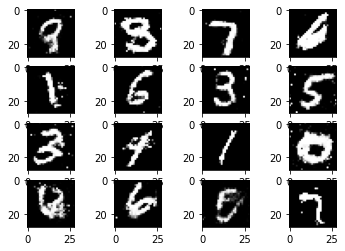

Epoch [26/50], step[1/15000], Discriminator Loss: 1.2560093402862549, Generator Loss: 0.7935268878936768
Epoch [26/50], step[1001/15000], Discriminator Loss: 1.3873836994171143, Generator Loss: 0.8465007543563843
Epoch [26/50], step[2001/15000], Discriminator Loss: 1.0607115030288696, Generator Loss: 0.8118547797203064
Epoch [26/50], step[3001/15000], Discriminator Loss: 1.3887473344802856, Generator Loss: 0.9726580381393433
Epoch [26/50], step[4001/15000], Discriminator Loss: 1.2455273866653442, Generator Loss: 0.8612083196640015
Epoch [26/50], step[5001/15000], Discriminator Loss: 1.6579020023345947, Generator Loss: 0.9902092218399048
Epoch [26/50], step[6001/15000], Discriminator Loss: 1.2005318403244019, Generator Loss: 0.6149393916130066
Epoch [26/50], step[7001/15000], Discriminator Loss: 1.277153730392456, Generator Loss: 1.1170706748962402
Epoch [26/50], step[8001/15000], Discriminator Loss: 1.2279540300369263, Generator Loss: 0.6991547346115112
Epoch [26/50], step[9001/15000],

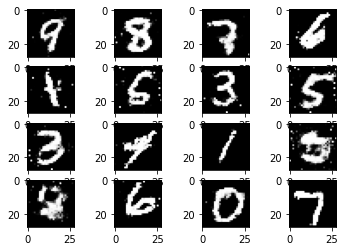

Epoch [27/50], step[1/15000], Discriminator Loss: 1.2677688598632812, Generator Loss: 0.8155602812767029
Epoch [27/50], step[1001/15000], Discriminator Loss: 1.2938318252563477, Generator Loss: 0.6858848333358765
Epoch [27/50], step[2001/15000], Discriminator Loss: 0.907211184501648, Generator Loss: 0.8263875246047974
Epoch [27/50], step[3001/15000], Discriminator Loss: 1.467479944229126, Generator Loss: 0.8227486610412598
Epoch [27/50], step[4001/15000], Discriminator Loss: 1.2684764862060547, Generator Loss: 0.9016330242156982
Epoch [27/50], step[5001/15000], Discriminator Loss: 1.5900139808654785, Generator Loss: 0.9848535060882568
Epoch [27/50], step[6001/15000], Discriminator Loss: 1.0547902584075928, Generator Loss: 0.5574173927307129
Epoch [27/50], step[7001/15000], Discriminator Loss: 0.980675220489502, Generator Loss: 0.9410319328308105
Epoch [27/50], step[8001/15000], Discriminator Loss: 1.226309895515442, Generator Loss: 0.7613067626953125
Epoch [27/50], step[9001/15000], Di

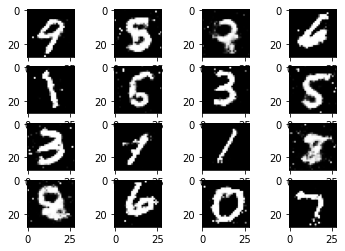

Epoch [28/50], step[1/15000], Discriminator Loss: 1.4326837062835693, Generator Loss: 0.7063872814178467
Epoch [28/50], step[1001/15000], Discriminator Loss: 1.015423059463501, Generator Loss: 0.782163143157959
Epoch [28/50], step[2001/15000], Discriminator Loss: 1.1577003002166748, Generator Loss: 0.8371067047119141
Epoch [28/50], step[3001/15000], Discriminator Loss: 1.2878247499465942, Generator Loss: 0.9122844934463501
Epoch [28/50], step[4001/15000], Discriminator Loss: 1.1394909620285034, Generator Loss: 0.7038103938102722
Epoch [28/50], step[5001/15000], Discriminator Loss: 1.3655210733413696, Generator Loss: 0.7342313528060913
Epoch [28/50], step[6001/15000], Discriminator Loss: 1.5300781726837158, Generator Loss: 0.9662737846374512
Epoch [28/50], step[7001/15000], Discriminator Loss: 1.2312577962875366, Generator Loss: 0.9579263925552368
Epoch [28/50], step[8001/15000], Discriminator Loss: 1.1570374965667725, Generator Loss: 1.0669474601745605
Epoch [28/50], step[9001/15000], 

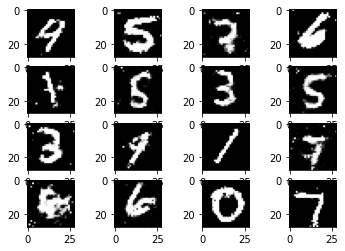

Epoch [29/50], step[1/15000], Discriminator Loss: 1.1440201997756958, Generator Loss: 0.9846289157867432
Epoch [29/50], step[1001/15000], Discriminator Loss: 1.3496719598770142, Generator Loss: 0.8649928569793701
Epoch [29/50], step[2001/15000], Discriminator Loss: 1.3138492107391357, Generator Loss: 0.6965141296386719
Epoch [29/50], step[3001/15000], Discriminator Loss: 1.5205879211425781, Generator Loss: 0.8958139419555664
Epoch [29/50], step[4001/15000], Discriminator Loss: 1.559267520904541, Generator Loss: 0.8074444532394409
Epoch [29/50], step[5001/15000], Discriminator Loss: 1.2746658325195312, Generator Loss: 1.0536386966705322
Epoch [29/50], step[6001/15000], Discriminator Loss: 1.3717780113220215, Generator Loss: 0.7966888546943665
Epoch [29/50], step[7001/15000], Discriminator Loss: 1.59328293800354, Generator Loss: 0.5036436319351196
Epoch [29/50], step[8001/15000], Discriminator Loss: 1.1372404098510742, Generator Loss: 0.6325435638427734
Epoch [29/50], step[9001/15000], D

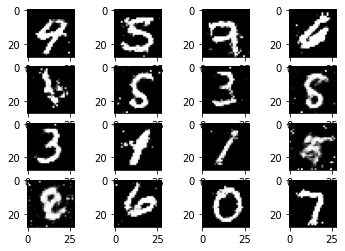

Epoch [30/50], step[1/15000], Discriminator Loss: 1.3586273193359375, Generator Loss: 0.8503767848014832
Epoch [30/50], step[1001/15000], Discriminator Loss: 1.4619932174682617, Generator Loss: 0.8190792202949524
Epoch [30/50], step[2001/15000], Discriminator Loss: 1.1302570104599, Generator Loss: 0.9995744228363037
Epoch [30/50], step[3001/15000], Discriminator Loss: 1.7162996530532837, Generator Loss: 0.8222874402999878
Epoch [30/50], step[4001/15000], Discriminator Loss: 1.5512863397598267, Generator Loss: 0.7387263774871826
Epoch [30/50], step[5001/15000], Discriminator Loss: 1.388627290725708, Generator Loss: 0.9733378887176514
Epoch [30/50], step[6001/15000], Discriminator Loss: 1.2888567447662354, Generator Loss: 1.029344916343689
Epoch [30/50], step[7001/15000], Discriminator Loss: 1.4395917654037476, Generator Loss: 0.8922513127326965
Epoch [30/50], step[8001/15000], Discriminator Loss: 1.3325233459472656, Generator Loss: 1.019484519958496
Epoch [30/50], step[9001/15000], Disc

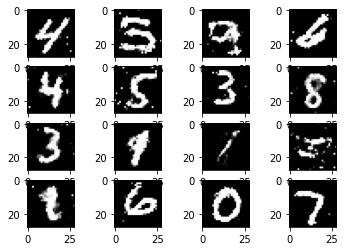

Epoch [31/50], step[1/15000], Discriminator Loss: 1.301153540611267, Generator Loss: 1.1390690803527832
Epoch [31/50], step[1001/15000], Discriminator Loss: 1.151403784751892, Generator Loss: 1.1547282934188843
Epoch [31/50], step[2001/15000], Discriminator Loss: 1.1467278003692627, Generator Loss: 0.5046522617340088
Epoch [31/50], step[3001/15000], Discriminator Loss: 1.4181020259857178, Generator Loss: 0.7316322326660156
Epoch [31/50], step[4001/15000], Discriminator Loss: 1.2684005498886108, Generator Loss: 0.9703067541122437
Epoch [31/50], step[5001/15000], Discriminator Loss: 1.254326343536377, Generator Loss: 0.8946515321731567
Epoch [31/50], step[6001/15000], Discriminator Loss: 1.1977238655090332, Generator Loss: 0.7059261798858643
Epoch [31/50], step[7001/15000], Discriminator Loss: 1.44387948513031, Generator Loss: 0.7936568260192871
Epoch [31/50], step[8001/15000], Discriminator Loss: 1.1268171072006226, Generator Loss: 0.8079919815063477
Epoch [31/50], step[9001/15000], Dis

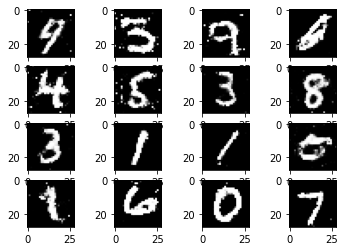

Epoch [32/50], step[1/15000], Discriminator Loss: 1.4215720891952515, Generator Loss: 0.6076319813728333
Epoch [32/50], step[1001/15000], Discriminator Loss: 1.715661644935608, Generator Loss: 0.7633824348449707
Epoch [32/50], step[2001/15000], Discriminator Loss: 1.359217882156372, Generator Loss: 0.8431906700134277
Epoch [32/50], step[3001/15000], Discriminator Loss: 1.1153678894042969, Generator Loss: 1.0500627756118774
Epoch [32/50], step[4001/15000], Discriminator Loss: 1.0014731884002686, Generator Loss: 0.7579808831214905
Epoch [32/50], step[5001/15000], Discriminator Loss: 1.3341889381408691, Generator Loss: 1.0420355796813965
Epoch [32/50], step[6001/15000], Discriminator Loss: 1.3298466205596924, Generator Loss: 0.7779800891876221
Epoch [32/50], step[7001/15000], Discriminator Loss: 1.3124254941940308, Generator Loss: 1.0163590908050537
Epoch [32/50], step[8001/15000], Discriminator Loss: 1.3755877017974854, Generator Loss: 1.2400434017181396
Epoch [32/50], step[9001/15000], 

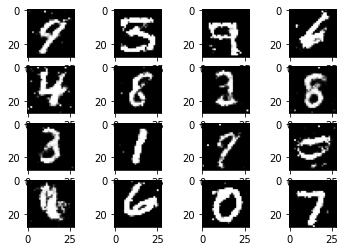

Epoch [33/50], step[1/15000], Discriminator Loss: 0.9259958267211914, Generator Loss: 0.7377879619598389
Epoch [33/50], step[1001/15000], Discriminator Loss: 1.6054794788360596, Generator Loss: 0.7297348976135254
Epoch [33/50], step[2001/15000], Discriminator Loss: 1.5636765956878662, Generator Loss: 0.9737135171890259
Epoch [33/50], step[3001/15000], Discriminator Loss: 1.322593331336975, Generator Loss: 0.8925395011901855
Epoch [33/50], step[4001/15000], Discriminator Loss: 1.6555297374725342, Generator Loss: 0.8798412084579468
Epoch [33/50], step[5001/15000], Discriminator Loss: 1.3293089866638184, Generator Loss: 0.9682526588439941
Epoch [33/50], step[6001/15000], Discriminator Loss: 1.7477355003356934, Generator Loss: 0.8908658623695374
Epoch [33/50], step[7001/15000], Discriminator Loss: 1.8336933851242065, Generator Loss: 0.7353181838989258
Epoch [33/50], step[8001/15000], Discriminator Loss: 1.9173704385757446, Generator Loss: 0.9380041360855103
Epoch [33/50], step[9001/15000],

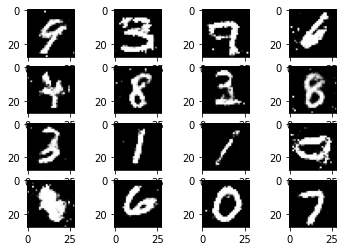

Epoch [34/50], step[1/15000], Discriminator Loss: 1.5601527690887451, Generator Loss: 0.7910213470458984
Epoch [34/50], step[1001/15000], Discriminator Loss: 1.378288984298706, Generator Loss: 0.744806706905365
Epoch [34/50], step[2001/15000], Discriminator Loss: 1.5187910795211792, Generator Loss: 0.8257988691329956
Epoch [34/50], step[3001/15000], Discriminator Loss: 1.1917119026184082, Generator Loss: 0.7417552471160889
Epoch [34/50], step[4001/15000], Discriminator Loss: 1.5945897102355957, Generator Loss: 0.8970558643341064
Epoch [34/50], step[5001/15000], Discriminator Loss: 1.2462918758392334, Generator Loss: 0.541343092918396
Epoch [34/50], step[6001/15000], Discriminator Loss: 1.4968645572662354, Generator Loss: 0.753157913684845
Epoch [34/50], step[7001/15000], Discriminator Loss: 1.3703073263168335, Generator Loss: 1.1333115100860596
Epoch [34/50], step[8001/15000], Discriminator Loss: 1.3328360319137573, Generator Loss: 0.9235762357711792
Epoch [34/50], step[9001/15000], Di

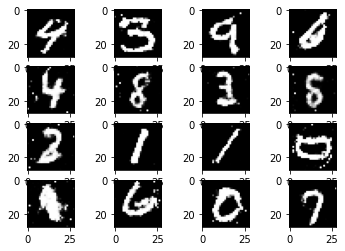

Epoch [35/50], step[1/15000], Discriminator Loss: 1.316763997077942, Generator Loss: 0.6439946293830872
Epoch [35/50], step[1001/15000], Discriminator Loss: 1.330053448677063, Generator Loss: 0.8593234419822693
Epoch [35/50], step[2001/15000], Discriminator Loss: 1.3691511154174805, Generator Loss: 0.5827606916427612
Epoch [35/50], step[3001/15000], Discriminator Loss: 1.2319135665893555, Generator Loss: 0.8173199892044067
Epoch [35/50], step[4001/15000], Discriminator Loss: 1.2440545558929443, Generator Loss: 0.9198291301727295
Epoch [35/50], step[5001/15000], Discriminator Loss: 1.4251035451889038, Generator Loss: 0.7010934352874756
Epoch [35/50], step[6001/15000], Discriminator Loss: 1.3432008028030396, Generator Loss: 0.7619070410728455
Epoch [35/50], step[7001/15000], Discriminator Loss: 1.6782160997390747, Generator Loss: 0.578822672367096
Epoch [35/50], step[8001/15000], Discriminator Loss: 0.9869461059570312, Generator Loss: 0.9662721157073975
Epoch [35/50], step[9001/15000], D

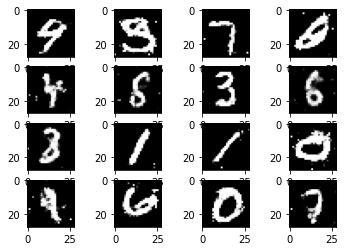

Epoch [36/50], step[1/15000], Discriminator Loss: 1.3040964603424072, Generator Loss: 0.8175767660140991
Epoch [36/50], step[1001/15000], Discriminator Loss: 1.877943754196167, Generator Loss: 0.6376203298568726
Epoch [36/50], step[2001/15000], Discriminator Loss: 1.2728381156921387, Generator Loss: 0.8780184984207153
Epoch [36/50], step[3001/15000], Discriminator Loss: 1.2466243505477905, Generator Loss: 1.0282390117645264
Epoch [36/50], step[4001/15000], Discriminator Loss: 1.6521965265274048, Generator Loss: 1.021942138671875
Epoch [36/50], step[5001/15000], Discriminator Loss: 1.2331801652908325, Generator Loss: 0.5923030376434326
Epoch [36/50], step[6001/15000], Discriminator Loss: 1.716296672821045, Generator Loss: 0.7186354994773865
Epoch [36/50], step[7001/15000], Discriminator Loss: 1.4390792846679688, Generator Loss: 1.017525315284729
Epoch [36/50], step[8001/15000], Discriminator Loss: 0.9678917527198792, Generator Loss: 0.7219157814979553
Epoch [36/50], step[9001/15000], Di

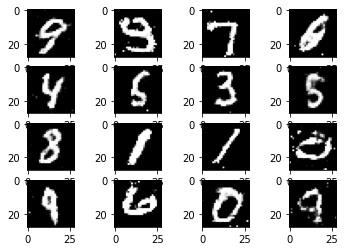

Epoch [37/50], step[1/15000], Discriminator Loss: 1.418197751045227, Generator Loss: 0.6779499650001526
Epoch [37/50], step[1001/15000], Discriminator Loss: 1.1862716674804688, Generator Loss: 0.732651948928833
Epoch [37/50], step[2001/15000], Discriminator Loss: 1.9185295104980469, Generator Loss: 0.6676139831542969
Epoch [37/50], step[3001/15000], Discriminator Loss: 1.1714110374450684, Generator Loss: 0.9302438497543335
Epoch [37/50], step[4001/15000], Discriminator Loss: 1.2879111766815186, Generator Loss: 0.625110924243927
Epoch [37/50], step[5001/15000], Discriminator Loss: 1.169919729232788, Generator Loss: 0.7051906585693359
Epoch [37/50], step[6001/15000], Discriminator Loss: 1.0724191665649414, Generator Loss: 0.819999098777771
Epoch [37/50], step[7001/15000], Discriminator Loss: 1.5303195714950562, Generator Loss: 0.7651047706604004
Epoch [37/50], step[8001/15000], Discriminator Loss: 1.4143190383911133, Generator Loss: 0.6355364918708801
Epoch [37/50], step[9001/15000], Dis

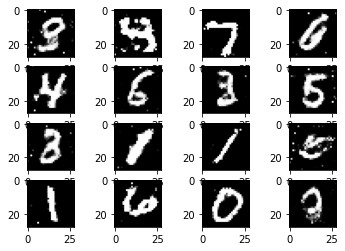

Epoch [38/50], step[1/15000], Discriminator Loss: 1.021440029144287, Generator Loss: 0.8320684432983398
Epoch [38/50], step[1001/15000], Discriminator Loss: 1.2215181589126587, Generator Loss: 0.6122350096702576
Epoch [38/50], step[2001/15000], Discriminator Loss: 1.7247793674468994, Generator Loss: 1.1037607192993164
Epoch [38/50], step[3001/15000], Discriminator Loss: 1.1950170993804932, Generator Loss: 0.9423409700393677
Epoch [38/50], step[4001/15000], Discriminator Loss: 1.7637274265289307, Generator Loss: 0.8000440001487732
Epoch [38/50], step[5001/15000], Discriminator Loss: 1.1297205686569214, Generator Loss: 1.3563487529754639
Epoch [38/50], step[6001/15000], Discriminator Loss: 1.434263825416565, Generator Loss: 0.8175790905952454
Epoch [38/50], step[7001/15000], Discriminator Loss: 0.7768218517303467, Generator Loss: 1.215801477432251
Epoch [38/50], step[8001/15000], Discriminator Loss: 1.5438873767852783, Generator Loss: 0.6390522718429565
Epoch [38/50], step[9001/15000], D

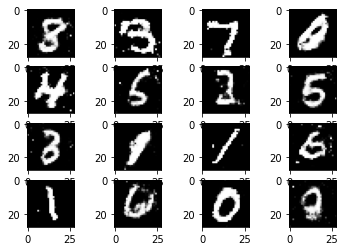

Epoch [39/50], step[1/15000], Discriminator Loss: 0.8574194312095642, Generator Loss: 0.7596772909164429
Epoch [39/50], step[1001/15000], Discriminator Loss: 1.325237512588501, Generator Loss: 0.7239001989364624
Epoch [39/50], step[2001/15000], Discriminator Loss: 1.118341326713562, Generator Loss: 0.8031636476516724
Epoch [39/50], step[3001/15000], Discriminator Loss: 1.2811915874481201, Generator Loss: 0.9003893136978149
Epoch [39/50], step[4001/15000], Discriminator Loss: 1.154528260231018, Generator Loss: 1.110624074935913
Epoch [39/50], step[5001/15000], Discriminator Loss: 1.618459701538086, Generator Loss: 0.8804726600646973
Epoch [39/50], step[6001/15000], Discriminator Loss: 1.5672473907470703, Generator Loss: 0.8125758171081543
Epoch [39/50], step[7001/15000], Discriminator Loss: 0.9968211650848389, Generator Loss: 0.8113892078399658
Epoch [39/50], step[8001/15000], Discriminator Loss: 1.3389976024627686, Generator Loss: 0.855499267578125
Epoch [39/50], step[9001/15000], Disc

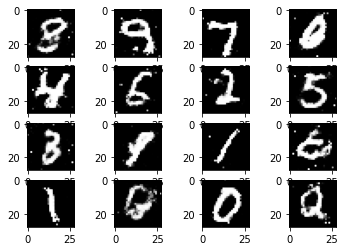

Epoch [40/50], step[1/15000], Discriminator Loss: 1.1948323249816895, Generator Loss: 0.7785468697547913
Epoch [40/50], step[1001/15000], Discriminator Loss: 1.2052735090255737, Generator Loss: 0.7615463733673096
Epoch [40/50], step[2001/15000], Discriminator Loss: 1.34297776222229, Generator Loss: 0.5736651420593262
Epoch [40/50], step[3001/15000], Discriminator Loss: 1.2793519496917725, Generator Loss: 0.7669287919998169
Epoch [40/50], step[4001/15000], Discriminator Loss: 1.62938392162323, Generator Loss: 1.1442649364471436
Epoch [40/50], step[5001/15000], Discriminator Loss: 1.6794230937957764, Generator Loss: 0.7903991341590881
Epoch [40/50], step[6001/15000], Discriminator Loss: 0.9568805694580078, Generator Loss: 0.8553302884101868
Epoch [40/50], step[7001/15000], Discriminator Loss: 1.2894129753112793, Generator Loss: 0.7527347803115845
Epoch [40/50], step[8001/15000], Discriminator Loss: 1.4801585674285889, Generator Loss: 0.7561468482017517
Epoch [40/50], step[9001/15000], Di

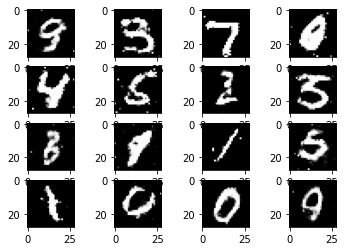

Epoch [41/50], step[1/15000], Discriminator Loss: 1.3382925987243652, Generator Loss: 0.8425981402397156
Epoch [41/50], step[1001/15000], Discriminator Loss: 0.9802073240280151, Generator Loss: 0.7302510142326355
Epoch [41/50], step[2001/15000], Discriminator Loss: 1.0301896333694458, Generator Loss: 0.5336235761642456
Epoch [41/50], step[3001/15000], Discriminator Loss: 1.4592666625976562, Generator Loss: 1.0188555717468262
Epoch [41/50], step[4001/15000], Discriminator Loss: 1.0784701108932495, Generator Loss: 0.8258892297744751
Epoch [41/50], step[5001/15000], Discriminator Loss: 1.1095948219299316, Generator Loss: 0.6640526056289673
Epoch [41/50], step[6001/15000], Discriminator Loss: 1.603464126586914, Generator Loss: 0.7846391201019287
Epoch [41/50], step[7001/15000], Discriminator Loss: 1.7620455026626587, Generator Loss: 0.763756275177002
Epoch [41/50], step[8001/15000], Discriminator Loss: 1.257859230041504, Generator Loss: 0.7010180354118347
Epoch [41/50], step[9001/15000], D

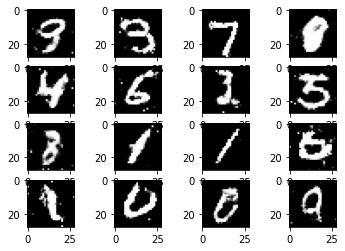

Epoch [42/50], step[1/15000], Discriminator Loss: 1.2109315395355225, Generator Loss: 0.9350073337554932
Epoch [42/50], step[1001/15000], Discriminator Loss: 1.4947457313537598, Generator Loss: 1.2153751850128174
Epoch [42/50], step[2001/15000], Discriminator Loss: 0.9916962385177612, Generator Loss: 0.7425311803817749
Epoch [42/50], step[3001/15000], Discriminator Loss: 1.2278034687042236, Generator Loss: 0.5585264563560486
Epoch [42/50], step[4001/15000], Discriminator Loss: 1.6392661333084106, Generator Loss: 0.8168751001358032
Epoch [42/50], step[5001/15000], Discriminator Loss: 1.3039716482162476, Generator Loss: 0.8538159132003784
Epoch [42/50], step[6001/15000], Discriminator Loss: 1.270929217338562, Generator Loss: 0.8025863170623779
Epoch [42/50], step[7001/15000], Discriminator Loss: 0.9709312915802002, Generator Loss: 1.0491257905960083
Epoch [42/50], step[8001/15000], Discriminator Loss: 1.0888575315475464, Generator Loss: 0.6697871685028076
Epoch [42/50], step[9001/15000],

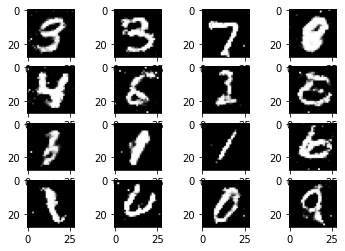

Epoch [43/50], step[1/15000], Discriminator Loss: 1.1747299432754517, Generator Loss: 1.0010550022125244
Epoch [43/50], step[1001/15000], Discriminator Loss: 1.5063647031784058, Generator Loss: 0.8590062856674194
Epoch [43/50], step[2001/15000], Discriminator Loss: 1.3343985080718994, Generator Loss: 0.8008068203926086
Epoch [43/50], step[3001/15000], Discriminator Loss: 0.9549509882926941, Generator Loss: 0.5935698747634888
Epoch [43/50], step[4001/15000], Discriminator Loss: 1.1961617469787598, Generator Loss: 0.6519894599914551
Epoch [43/50], step[5001/15000], Discriminator Loss: 1.5355494022369385, Generator Loss: 0.8148269057273865
Epoch [43/50], step[6001/15000], Discriminator Loss: 1.632748007774353, Generator Loss: 0.6805899739265442
Epoch [43/50], step[7001/15000], Discriminator Loss: 1.4505705833435059, Generator Loss: 1.1329796314239502
Epoch [43/50], step[8001/15000], Discriminator Loss: 1.59274423122406, Generator Loss: 0.9136266112327576
Epoch [43/50], step[9001/15000], D

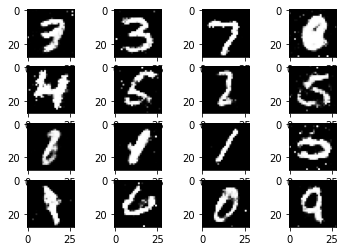

Epoch [44/50], step[1/15000], Discriminator Loss: 0.9356301426887512, Generator Loss: 1.06588613986969
Epoch [44/50], step[1001/15000], Discriminator Loss: 1.33545982837677, Generator Loss: 0.7967603802680969
Epoch [44/50], step[2001/15000], Discriminator Loss: 1.4198203086853027, Generator Loss: 0.9851475954055786
Epoch [44/50], step[3001/15000], Discriminator Loss: 1.1451494693756104, Generator Loss: 1.0620921850204468
Epoch [44/50], step[4001/15000], Discriminator Loss: 1.0126864910125732, Generator Loss: 0.7165105938911438
Epoch [44/50], step[5001/15000], Discriminator Loss: 1.1501017808914185, Generator Loss: 0.7735968828201294
Epoch [44/50], step[6001/15000], Discriminator Loss: 1.0797736644744873, Generator Loss: 0.5439785718917847
Epoch [44/50], step[7001/15000], Discriminator Loss: 1.2457239627838135, Generator Loss: 0.7784968614578247
Epoch [44/50], step[8001/15000], Discriminator Loss: 1.1621689796447754, Generator Loss: 0.7592953443527222
Epoch [44/50], step[9001/15000], Di

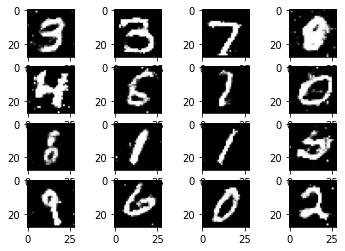

Epoch [45/50], step[1/15000], Discriminator Loss: 1.370524287223816, Generator Loss: 1.1276381015777588
Epoch [45/50], step[1001/15000], Discriminator Loss: 1.0113208293914795, Generator Loss: 0.7158241271972656
Epoch [45/50], step[2001/15000], Discriminator Loss: 1.3048192262649536, Generator Loss: 1.022929072380066
Epoch [45/50], step[3001/15000], Discriminator Loss: 1.0005334615707397, Generator Loss: 0.6711199283599854
Epoch [45/50], step[4001/15000], Discriminator Loss: 1.9157541990280151, Generator Loss: 0.787124514579773
Epoch [45/50], step[5001/15000], Discriminator Loss: 1.8309732675552368, Generator Loss: 0.8103981614112854
Epoch [45/50], step[6001/15000], Discriminator Loss: 1.2324764728546143, Generator Loss: 0.7910846471786499
Epoch [45/50], step[7001/15000], Discriminator Loss: 1.3989583253860474, Generator Loss: 0.5601717233657837
Epoch [45/50], step[8001/15000], Discriminator Loss: 1.4783875942230225, Generator Loss: 0.6347342133522034
Epoch [45/50], step[9001/15000], D

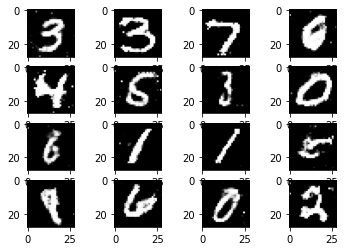

Epoch [46/50], step[1/15000], Discriminator Loss: 1.2724372148513794, Generator Loss: 0.9221669435501099
Epoch [46/50], step[1001/15000], Discriminator Loss: 1.1200779676437378, Generator Loss: 0.8076610565185547
Epoch [46/50], step[2001/15000], Discriminator Loss: 1.2113258838653564, Generator Loss: 0.8027331233024597
Epoch [46/50], step[3001/15000], Discriminator Loss: 1.3106824159622192, Generator Loss: 1.0886921882629395
Epoch [46/50], step[4001/15000], Discriminator Loss: 1.6004242897033691, Generator Loss: 1.1845149993896484
Epoch [46/50], step[5001/15000], Discriminator Loss: 1.4445252418518066, Generator Loss: 0.9525551795959473
Epoch [46/50], step[6001/15000], Discriminator Loss: 1.3165552616119385, Generator Loss: 0.8007706999778748
Epoch [46/50], step[7001/15000], Discriminator Loss: 1.0473631620407104, Generator Loss: 0.6567796468734741
Epoch [46/50], step[8001/15000], Discriminator Loss: 1.3771171569824219, Generator Loss: 1.0014159679412842
Epoch [46/50], step[9001/15000]

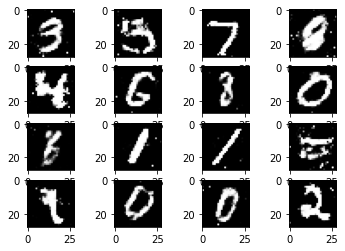

Epoch [47/50], step[1/15000], Discriminator Loss: 0.8720437288284302, Generator Loss: 0.8471602201461792
Epoch [47/50], step[1001/15000], Discriminator Loss: 0.831149160861969, Generator Loss: 0.7503679990768433
Epoch [47/50], step[2001/15000], Discriminator Loss: 1.2115367650985718, Generator Loss: 0.45911896228790283
Epoch [47/50], step[3001/15000], Discriminator Loss: 1.4584152698516846, Generator Loss: 0.9723469018936157
Epoch [47/50], step[4001/15000], Discriminator Loss: 1.577164888381958, Generator Loss: 0.7526166439056396
Epoch [47/50], step[5001/15000], Discriminator Loss: 1.4935917854309082, Generator Loss: 0.8690090179443359
Epoch [47/50], step[6001/15000], Discriminator Loss: 1.3487820625305176, Generator Loss: 0.750057578086853
Epoch [47/50], step[7001/15000], Discriminator Loss: 1.5643450021743774, Generator Loss: 0.7806075215339661
Epoch [47/50], step[8001/15000], Discriminator Loss: 1.2527509927749634, Generator Loss: 0.8845547437667847
Epoch [47/50], step[9001/15000], 

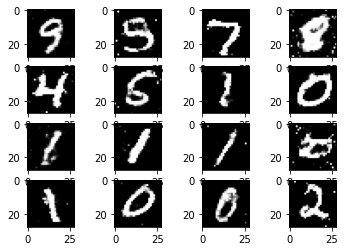

Epoch [48/50], step[1/15000], Discriminator Loss: 1.7310428619384766, Generator Loss: 0.9405138492584229
Epoch [48/50], step[1001/15000], Discriminator Loss: 1.0851960182189941, Generator Loss: 0.7955109477043152
Epoch [48/50], step[2001/15000], Discriminator Loss: 1.3555800914764404, Generator Loss: 0.6677571535110474
Epoch [48/50], step[3001/15000], Discriminator Loss: 1.3067524433135986, Generator Loss: 0.7788031101226807
Epoch [48/50], step[4001/15000], Discriminator Loss: 1.4050109386444092, Generator Loss: 0.9209528565406799
Epoch [48/50], step[5001/15000], Discriminator Loss: 0.9893983602523804, Generator Loss: 0.845192015171051
Epoch [48/50], step[6001/15000], Discriminator Loss: 1.1110877990722656, Generator Loss: 0.6732209324836731
Epoch [48/50], step[7001/15000], Discriminator Loss: 1.4762704372406006, Generator Loss: 0.7465813159942627
Epoch [48/50], step[8001/15000], Discriminator Loss: 0.9789260625839233, Generator Loss: 0.7107716798782349
Epoch [48/50], step[9001/15000],

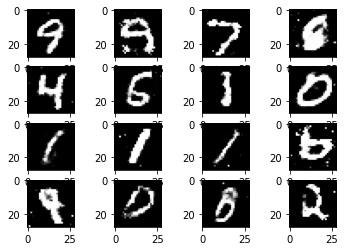

Epoch [49/50], step[1/15000], Discriminator Loss: 1.796937108039856, Generator Loss: 0.6871916055679321
Epoch [49/50], step[1001/15000], Discriminator Loss: 1.6000127792358398, Generator Loss: 0.9640985131263733
Epoch [49/50], step[2001/15000], Discriminator Loss: 1.7188446521759033, Generator Loss: 0.8736613988876343
Epoch [49/50], step[3001/15000], Discriminator Loss: 1.844820261001587, Generator Loss: 0.8774908185005188
Epoch [49/50], step[4001/15000], Discriminator Loss: 1.3617210388183594, Generator Loss: 0.8228321671485901
Epoch [49/50], step[5001/15000], Discriminator Loss: 1.6382725238800049, Generator Loss: 0.7879267334938049
Epoch [49/50], step[6001/15000], Discriminator Loss: 1.3223176002502441, Generator Loss: 0.6818704605102539
Epoch [49/50], step[7001/15000], Discriminator Loss: 0.943000316619873, Generator Loss: 0.49866408109664917
Epoch [49/50], step[8001/15000], Discriminator Loss: 1.1851476430892944, Generator Loss: 0.65242600440979
Epoch [49/50], step[9001/15000], Di

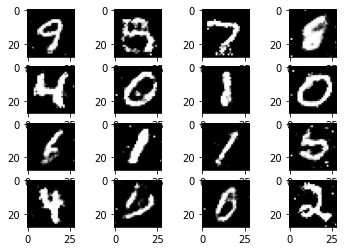

Epoch [50/50], step[1/15000], Discriminator Loss: 1.1124645471572876, Generator Loss: 0.8979504704475403
Epoch [50/50], step[1001/15000], Discriminator Loss: 1.671506404876709, Generator Loss: 1.0393741130828857
Epoch [50/50], step[2001/15000], Discriminator Loss: 0.8923509120941162, Generator Loss: 0.5624396204948425
Epoch [50/50], step[3001/15000], Discriminator Loss: 1.3561941385269165, Generator Loss: 0.6097924709320068
Epoch [50/50], step[4001/15000], Discriminator Loss: 1.4411625862121582, Generator Loss: 0.8669461011886597
Epoch [50/50], step[5001/15000], Discriminator Loss: 1.0690094232559204, Generator Loss: 1.1680445671081543
Epoch [50/50], step[6001/15000], Discriminator Loss: 1.1787300109863281, Generator Loss: 0.9089032411575317
Epoch [50/50], step[7001/15000], Discriminator Loss: 1.3731813430786133, Generator Loss: 0.9577153325080872
Epoch [50/50], step[8001/15000], Discriminator Loss: 1.437622308731079, Generator Loss: 0.7269538044929504
Epoch [50/50], step[9001/15000], 

In [11]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# set number of epochs and initialize figure counter
num_epochs = 50
num_batches = len(trainloader)

for epoch in range(num_epochs):
    for n, (images, _) in enumerate(trainloader):
        images = Variable(images).cuda()
        real_labels = Variable(torch.ones(images.size(0))).cuda()
        
        # Sample from generatortrain_discriminator
        noise = Variable(torch.randn(images.size(0), 100)).cuda()

        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0))).cuda()
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), 100)).cuda()
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)

        
        test_images = generator(test_noise)
        if n  % 15000 == 0:
          for k in range(num_test_samples):
              plt.subplot(4, 4, k + 1)
              plt.imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys_r')
          plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
          plt.show()
            
        if n % 1000 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], step[{n+1}/{num_batches}], Discriminator Loss: {d_loss.item()}, Generator Loss: {g_loss.item()}')
                


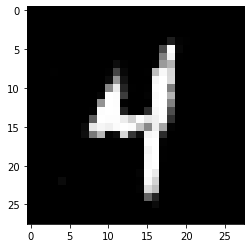

In [15]:
num_test_samples = 16
test_noise_new = Variable(torch.randn(5, 100)).cuda()
with torch.no_grad():
        gen_image = generator(test_noise_new).cpu()
        plt.imshow(gen_image[4,0,:,:], cmap='gray')


In [0]:
#################################################
##############TOP LOSS TRAINER###################
#################################################
torch.save(generator.state_dict(), 'Standard_Gan_EPOCHS_50.pt')

In [0]:

dtype=torch.float32
''' Change to touch.double to try gradient check '''
# dtype=torch.double
PRINT = False

class Diagramlayer(Function):
    def __init__(self):
        super(Diagramlayer, self).__init__()
        # self.p = chopt.Cohomology()
        # self.p.readIn(triangulation_file)
        # self.p.init()

    def init_filtration(self, faces):
        F = faces
        f = d.Filtration()
        for i in range(F.shape[0]):
            if len(F[i]) == 4:
                c = d.closure([d.Simplex([int(F[i][0]), int(F[i][1]), int(F[i][2]), int(F[i][3])], 0.0)], 3) #np.array(0).astype(DTYPE))],2)
            elif len(F[i]) == 3:
                c = d.closure([d.Simplex([int(F[i][0]), int(F[i][1]), int(F[i][2])], 0.0)], 3)
            for j in c:
                f.append(j)
        return f

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, x, F):
        if PRINT: print("*** dgm start")
        start_time = time.time()
        function_values = x
        # list of function values on vertices, and maximal dimension it will return 0,1,2,3
        function_useable = function_values.data.numpy().flatten()

        dgms, Tbl = computePersistence(F, -1.0 * function_useable.reshape(1,-1))
        num_dgm_pts = np.max([len(dgms[0]), len(dgms[1]), len(dgms[2])])
        dgms_inds = -1 * np.ones([3, num_dgm_pts, 2])
        if len(dgms[0]) > 0:
            dgms_inds[0][:len(dgms[0])] = np.array(dgms[0])[:, [2,3]]
        if len(dgms[1]) > 0:
            dgms_inds[1][:len(dgms[1])] = np.array(dgms[1])[:, [2,3]]
        if len(dgms[2]) > 0:
            dgms_inds[2][:len(dgms[2])] = np.array(dgms[2])[:, [2,3]]
        dgms_inds[np.where(dgms_inds == np.inf)] = -1

        vertices_indices = dgms_inds
        corr_function_values = -np.inf * np.ones(vertices_indices.shape)
        dgm = vertices_indices
        for i in range(0, len(dgm)):
            if len(dgm[i]) > 0:
                dgmi = np.unique( np.array(dgm[i]), axis=0 ).astype(np.int)
                corr_f_values = function_useable[dgmi]
                ''' Change to -1.0 for gradient check '''
                corr_f_values[np.where(dgmi == -1)] = -np.inf # -1.0
                corr_function_values[i][:np.min([corr_f_values.shape[0], num_dgm_pts])] = corr_f_values[:np.min([corr_f_values.shape[0], num_dgm_pts])]
                vertices_indices[i][:np.min([len(dgmi), num_dgm_pts])] = dgmi[:np.min([len(dgmi), num_dgm_pts])]

        output = torch.tensor(corr_function_values).type(dtype)
        ctx.save_for_backward(x, torch.tensor(vertices_indices).type(dtype), output)
        if PRINT: print("*** dgm done", time.time() - start_time)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        input, vertices_indices, output = ctx.saved_variables
        grad_input = torch.zeros(input.shape).type(dtype)
        output[output > -np.inf] = 1
        output[output == -np.inf] = 0
        np_vertices_indices = vertices_indices.numpy()
        list_of_unique_indices = np.unique(np_vertices_indices.flatten())
        grad_intermediate = output * grad_output # (dgms, dgm_pts, 2)
        for i in range(len(list_of_unique_indices)):
            index = list_of_unique_indices[i]
            if index > -1:
                index_into_grad_output = np.where(np_vertices_indices == index)
                grad_input[int(index)] = torch.sum( grad_intermediate[index_into_grad_output] )
        return grad_input, None

In [0]:

dtype = torch.float32

''' Example of how to construct a cost function based on the persistence diagrams. '''
def cost_function(dgms):
    ''' Undefined are -1.0 for our rips and infinite are at saturation value '''
    dgm0 = dgms[0].type(dtype).clone()
    min_value = -1.0 # not always true, but can be assumed in most contexts
    dgm0[dgm0 == -np.inf] = min_value
    NAN = torch.tensor(float('nan')).type(dtype)
    lifetimes0 = torch.abs(dgm0[:,1]-dgm0[:,0])
    lifetimes0[lifetimes0 != lifetimes0] = 0
    sorted_d_dgm0, indsD0 = torch.sort( dgm0[:,1][dgm0[:,1] > -np.inf], 0)
    sorted0, inds0 = torch.sort(lifetimes0, 0, descending=True)

    cost = torch.add(
        torch.Tensor([0.0]),
        torch.mul(torch.sum(torch.abs(sorted0[1:1+10000])), 1.0),
        #torch.mul(torch.sum(torch.abs(sorted1[0:0+10000])), 1.0),
    )
    return cost

def top_cost(W, diagramlayer, filtration):
    dgms = diagramlayer(W.view(-1), filtration)
    return cost_function(dgms)

''' Example of how to run the cost over a batch '''
def top_batch_cost(gen_imgs, diagramlayer, filtration):
    start_time = time.time()
    axis=0
    costs = torch.stack([
        top_cost(x_i.view(-1), diagramlayer, filtration) for i, x_i in enumerate(torch.unbind(gen_imgs, dim=axis), 0)
    ], dim=axis)
    avg = torch.mean(costs.view(-1))
    print("top_batch_cost", "time: ", time.time() - start_time, "cost: ", avg)
    return avg
    ''' *** End Topology *** '''

def maxPolys(dgm1):
    b, d = dgm1[:, np.arange(0, dgm1.shape[1]-1,2)], dgm1[:, np.arange(1, dgm1.shape[1],2)]
    lifetimes = torch.abs(b - d)
    sorted, argsmax = torch.sort(lifetimes, dim=1, descending=True)
    #print sorted.shape, argsmax.shape # (64, 27)
    #argsmax = np.argsort(lifetimes)[::-1]
    #p1,p2,p3,p4 = np.sum(lifetimes[argsmax[:1]]),np.sum(lifetimes[argsmax[:2]]),np.sum(lifetimes[argsmax[:3]]),np.sum(lifetimes[argsmax[:4]])
    #print torch.sum(sorted[:,:2], dim=1).shape
    polys = torch.stack([
            torch.unsqueeze(torch.sum(sorted[:,:1], dim=1), dim=1),
            torch.unsqueeze(torch.sum(sorted[:,:2], dim=1), dim=1),
            torch.unsqueeze(torch.sum(sorted[:,:3], dim=1), dim=1),
            torch.unsqueeze(torch.sum(sorted[:,:4], dim=1), dim=1),
        ], dim=1)

    #print polys.shape # (64,4,1)
    polys = polys[:,:,0]
    return polys

def sumPolys(dgm1):
    b, d = dgm1[:, np.arange(0, dgm1.shape[1]-1,2)], dgm1[:, np.arange(1, dgm1.shape[1],2)]
    lifetimes = torch.abs(b - d)
    sorted, argsmax = torch.sort(lifetimes, dim=1, descending=True)
    polys = torch.unsqueeze(torch.sum(sorted, dim=1), dim=1)
    return polys

def top_features(x, diagramlayer, filtration, dim=1):
    # dgmsTop = diagramlayer(x.view(-1), filtration)
    # dgmsTop = dgmsTop.detach().numpy()
    # dgm1 = dgmsTop[1]
    # dgm1 = np.delete(dgm1, np.where((dgm1 == (-np.inf, -np.inf)).all(axis=1)), axis=0)
    # dgm1 = dgm1.flatten()
    #print("top_features", x)
    dgms = diagramlayer(x.view(-1), filtration)
    dgm1 = dgms[dim].type(dtype).clone()
    lifetimes1 = torch.abs(dgm1[:,1]-dgm1[:,0])
    lifetimes1[lifetimes1 != lifetimes1] = 0
    #sorted_d_dgm1, indsD1 = torch.sort( dgm1[:,1][dgm1[:,1] > -np.inf], 0)
    sorted1, inds1 = torch.sort(lifetimes1, 0, descending=True)
    p1, p2, p3, p4 = torch.sum(sorted1[:1]), torch.sum(sorted1[:2]), torch.sum(sorted1[:3]), torch.sum(sorted1[:4])
    #p1, p2, p3, p4 = torch.sum(sorted1[1:2]), torch.sum(sorted1[1:3]), torch.sum(sorted1[1:4]), torch.sum(sorted1[1:10])
    #print p1, p2, p3, p4
    polys = torch.stack([
            torch.unsqueeze(p1, dim=0),
            torch.unsqueeze(p2, dim=0),
            torch.unsqueeze(p3, dim=0),
            torch.unsqueeze(p4, dim=0),
        ], dim=1)
    #print polys
    polys = polys[0]
    return polys

def top_features_01(x, diagramlayer, filtration):
    dgms = diagramlayer(x.view(-1), filtration)
    ''' dim 0 '''
    dgm = dgms[0].type(dtype).clone()
    lifetimes = torch.abs(dgm[:,1]-dgm[:,0])
    lifetimes[lifetimes != lifetimes] = 0
    sorted, inds = torch.sort(lifetimes, 0, descending=True)
    a1, a2, a3, a4 = torch.sum(sorted[1:2]), torch.sum(sorted[1:3]), torch.sum(sorted[1:4]), torch.sum(sorted[1:10])
    ''' dim 1 '''
    dgm = dgms[1].type(dtype).clone()
    lifetimes = torch.abs(dgm[:,1]-dgm[:,0])
    lifetimes[lifetimes != lifetimes] = 0
    sorted, inds = torch.sort(lifetimes, 0, descending=True)
    p1, p2, p3, p4 = torch.sum(sorted[:1]), torch.sum(sorted[:2]), torch.sum(sorted[:3]), torch.sum(sorted[:4])
    polys = torch.stack([
            torch.unsqueeze(a1, dim=0),
            torch.unsqueeze(a2, dim=0),
            torch.unsqueeze(a3, dim=0),
            torch.unsqueeze(a4, dim=0),
            torch.unsqueeze(p1, dim=0),
            torch.unsqueeze(p2, dim=0),
            torch.unsqueeze(p3, dim=0),
            torch.unsqueeze(p4, dim=0),
        ], dim=1)
    #print polys
    polys = polys[0]
    return polys

def top_batch_features(input, diagramlayer, filtration, dim=1):
    #print(gen_imgs.shape)
    start_time = time.time()
    axis=0
    #print("input",input)
    feats = torch.stack([
        top_features(x_i.view(-1), diagramlayer, filtration, dim) for i, x_i in enumerate(torch.unbind(input, dim=axis), 0)
    ], dim=axis)
    #avg = torch.mean(costs.view(-1))
    print("feats", "time: ", time.time() - start_time)
    #print feats.shape
    return feats

In [0]:


# Returns enhanced diagram from a filtration
# dgm - a dictionary indexed by dimension
# Note:
#	if death time is infinite - then the second pairing is meaningless
# 	each dictionarry is a list of 4-tuples
#		(birth time, death time, birth vertex, death vertex)
# Input: m is the output of homology_persistence(f),
#        f is a filtration
#        Tbl is a dictionary from simplex to vertex (depends on the function)
def returndgm(m,f,Tbl):
	dgm = {}
	for i in range(len(m)-1):
		dgm[i] = []
    # Tbl is a dictionary from simplex to vertex (depends on the function) / from simplex to two points (three points cause includes value)
    # b_value_i, d_value_i, b_e_b (or -1), b_e_d (or -1), d_e_b (or -1), d_e_d (or -1)
	#point_index_to_points_indices = defaultdict(lambda: [])
	for i in range(len(m)-1):
		if m.pair(i) < i: continue      # skip negative simplices
		dim = int(f[i].dimension())
		pair = m.pair(i) # now an edge
		if pair != m.unpaired and f[pair].data-f[i].data > 0:
			b_a, d_a = Tbl[i], Tbl[pair] # FROM TABLE!
			dgm[dim].append( [f[i].data, f[pair].data, b_a[0], b_a[1], d_a[0], d_a[1]] )
		elif m.pair(i) == m.unpaired:
			b_a = Tbl[i]
			dgm[dim].append([f[i].data, np.inf, b_a[0], b_a[1], -1, -1])
	return dgm #, point_index_to_points_indices

# currently the fastest update procedure
# takes in a filtration F and a vector fnew of new
# function values defined on the vertices
# TODO: check if we update Tbl is it faster
#       than creating it from scratch each time
''' OBS: Don't think it's working for homology classes of dimension 2 '''
def computePersistenceflag(F):
	# update filtration
	# TODO: F and fnew doesn't have to have the same number of decimals!!!!!
	Tbl = {} # From simplex to attaching edge [a,b,value]
	#round_decimals = 10
	# SETTING IT TO s.data changes the float, must be somthing with the filtration structure
	F.sort() # so we know we are visting lover dimension before higher dimensions
	for s in F:
		index_s = F.index(s)
		if s.dimension() == 0:
			Tbl[index_s] = [-1, -1, 0]
		elif s.dimension() == 1:
			max_edge = [s[0], s[1], s.data]
			Tbl[index_s] = max_edge
		elif s.dimension() == 2: # s is now a triangle
			edges = [F.index(b) for b in s.boundary()]
			edges_data = [F[e].data for e in edges]
			edge_index = np.argmax(np.array([edges_data]))
			attaching = [F[edges[edge_index]][0], F[edges[edge_index]][1], edges_data[edge_index]]
			Tbl[index_s] = attaching
		elif s.dimension() == 3: # s is now a tetrahedron
			edges_triples = [Tbl[F.index(b)] for b in s.boundary()]
			edges_data = [e[2] for e in edges_triples]
			edge_index = np.argmax(np.array([edges_data]))
			attaching = edges_triples[edge_index]
			Tbl[index_s] = attaching
		else:
			print("WARNING-topologicalutils: something is wrong. Too high dimensional")
			assert(False)

	m = d.homology_persistence(F) # compute persistence
	dgms = returndgm(m,F,Tbl) # compute diagrams
	return dgms, Tbl  # return

In [0]:

dtype=torch.float32 # torch.double #torch.float32
PLOT = True

''' OBS: -1.0 are used as a token value for dgm values and indicies!!!!!! '''
class DiagramlayerRips(Function):

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, x, saturation=None, maxdim=1, verbose=False):
        MAX_DIMENSION = maxdim + 1 # maximal simplex dimension
        if verbose: print("*** dgm start")
        if saturation == None:
            SATURATION_VALUE = 3.1
            print("==== WARNING: NO SATURATION VALUE GIVEN, {}".format(SATURATION_VALUE))
        else:
            SATURATION_VALUE = saturation

        start_time = time.time()
        function_values = x
        # list of function values on vertices, and maximal dimension it will return 0,1,2,3
        function_useable = function_values.data.numpy()
        ''' 2 is max homology dimension '''
        ''' returns (sorted) filtration filled with the k-skeleton of the clique complex built on the points at distance at most r from each other '''
        F = d.fill_rips(function_useable, MAX_DIMENSION, SATURATION_VALUE)
        # F.sort() # this is done in computePersistence

        dgms, Tbl = computePersistenceflag(F)
        max_pts = np.max([len(dgms[i]) for i in range(maxdim+1)])
        num_dgm_pts = max_pts
        ''' -1 is used later '''
        dgms_inds = -1 * np.ones([maxdim+1, num_dgm_pts, 4])
        dgms_values = -np.inf * np.ones([maxdim+1, num_dgm_pts, 2]) # -1.0 * np.ones([3, num_dgm_pts, 2])
        for dim in range(maxdim+1):
            if len(dgms[dim]) > 0:
                dgm = np.array(dgms[dim])
                dgm[dgm == np.inf] = SATURATION_VALUE
                l = np.min([num_dgm_pts, len(dgm)])
                arg_sort = np.argsort(np.abs(dgm[:,1] - dgm[:,0]))[::-1]
                dgms_inds[dim][:l] = dgm[arg_sort[:l], 2:6]
                dgms_values[dim][:l] = dgm[arg_sort[:l], 0:2]

        dgms_inds = dgms_inds.reshape([maxdim+1, num_dgm_pts, 2, 2])
        #print dgms_values
        #dgms_values[dgms_values == np.inf] = SATURATION_VALUE #-1.0, Won't show up as inifinite, but good enough
        output = torch.tensor(dgms_values).type(dtype)
        ctx.save_for_backward(x, torch.tensor(dgms_inds).type(dtype), output, torch.tensor(verbose))
        if verbose: print("*** dgm done", time.time() - start_time)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        input, dgms_inds, dgms_values, verbose = ctx.saved_variables
        if verbose: print("*** dgm back")
        start_time = time.time()

        points = input.data.numpy()
        output = dgms_values.detach().numpy()
        grad_input = torch.zeros(input.shape).type(dtype)

        # MASK to only care about relevant spots later one
        output[output == np.inf] = -np.inf # death_value infinite doesn't correspond to a simplex
        output[output > -np.inf] = 1 # actual values that map to simplices
        output[output == -np.inf] = 0 # float('NaN') # 0 # dont affect the gradient, since they dont exist, didn't have matches, just because we want to keep matrix structure

        np_dgms_inds = dgms_inds.data.numpy().astype(np.int) # (3, 18424, 2, 2)
        # print np_dgms_inds.shape # (3, 18424, 4)
        list_of_unique_indices = np.unique(np_dgms_inds.flatten())
        grad_intermediate = output * grad_output.detach().numpy() # Not necessary? (dgms, dgm_pts, 2)
        ''' will have incorrect mappings, but these will never be used? '''
        pts_of_inds = points[np_dgms_inds]
        #print "pts_of_inds", pts_of_inds.shape # (3, 50, 2, 2, 2)

        for i in range(len(list_of_unique_indices)):
            index = int(list_of_unique_indices[i]) # index into input, get all that responds to a point-index
            ''' Not mapped anyhwere, set above '''
            if index > -1:
                index_into_dgms_inds = np.argwhere(np_dgms_inds == index)
                index_into_dgms_inds = index_into_dgms_inds.transpose()
                index_into_dgms_inds_partners = np.copy(index_into_dgms_inds)
                index_into_dgms_inds_partners[-1, :] = np.remainder(index_into_dgms_inds[-1, :] + 1, 2)
                intermediate = pts_of_inds[list(index_into_dgms_inds)] - pts_of_inds[list(index_into_dgms_inds_partners)] #- dgms_inds_to_points[np.remainder(np.array(index_into_dgms_inds)+1, 2)]
                ''' No 1.0/2 factor for dionysus '''
                #print("intermediate", intermediate)
                ''' Dividing by np.linalg.norm for zero norm has unintended consequences '''
                norms = np.linalg.norm(intermediate, axis=1)
                norms[norms == 0] = 1.0
                intermediate = ( intermediate.transpose() / norms).transpose()
                inds_into_grad_output = index_into_dgms_inds[:-1, :]
                grad_output_and_intermediate = (intermediate.transpose() * grad_intermediate[ list(inds_into_grad_output) ]).transpose()
                update = np.sum( grad_output_and_intermediate.reshape([-1, input.shape[1]]), axis=0 )
                grad_input[int(index)] = torch.tensor(update).type(dtype)
        if verbose: print("*** dgm back done", time.time() - start_time)
        return grad_input, None, None, None

In [0]:


# Get boundary for a certain filtration value <= max_f_value, a basis for Dk+1(Ck+1) in Ck
# return (tot_num_simplicies, num_basis_vectors)
def boundary_basis(filtration, max_f_value, dimension):
	f = filtration
	f.sort()
	R = d.homology_persistence(f) # compute persistence
	# dgms = returndgm(m,F,Tbl)
	basis = []
	tot_num_simplicies = len(R)
	#print("boundary_basis")
	for i in range(tot_num_simplicies): # iterate over columns
		if R.pair(i) < i: # This is a boundary column
			birth = f[i].data
			dim = int(f[i].dimension())
			col = R[i]
			if dim == (dimension+1) and birth <= max_f_value:
				assert(len(col) > 0)
				chain = np.zeros(tot_num_simplicies)
				inds = [l.index for l in col]
				chain[inds] = 1
				basis.append(chain)
	basis = np.array(basis).T
	#print basis.shape
	return basis

# Returns enhanced diagram from a filtration
# dgm - a dictionary indexed by dimension
# Note:
#	if death time is infinite - then the second pairing is meaningless
# 	each dictionarry is a list of 4-tuples
#		(birth time, death time, birth vertex, death vertex)
# Input: m is the output of homology_persistence(f),
#        f is a filtration
#        Tbl is a dictionary from simplex to vertex (depends on the function)
def returndgm(m,f,Tbl):
	dgm = {}
	dgm[0] = []
	dgm[1] = []
	dgm[2] = []
	#dgm[3] = []

	for i in range(len(m)):
		if m.pair(i) < i: continue      # skip negative simplices
		dim = int(f[i].dimension())
		if m.pair(i) != m.unpaired and f[m.pair(i)].data-f[i].data > 0:
			dgm[dim].append([f[i].data, f[m.pair(i)].data, Tbl[f[i]], Tbl[f[m.pair(i)]]] )
		elif m.pair(i) == m.unpaired :
			dgm[dim].append([f[i].data, np.inf, Tbl[f[i]], np.inf] )
	return dgm


# currently the fastest update procedure
# takes in a filtration F and a vector fnew of new
# function values defined on the vertices
# TODO: check if we update Tbl is it faster
#       than creating it from scratch each time
def computePersistence(F,fnew):
	# update filtration
	# TODO: F and fnew doesn't have to have the same number of decimals!!!!!
	Tbl = {}
	# SETTING IT TO s.data changes the float, must be somthing with the filtration structure
	for s in F:
		if s.dimension() == 0:
			s.data = fnew[0,s[0]]
			Tbl[s] = s[0]
		elif s.dimension() == 1:
			max_value = np.max(np.array([ fnew[0,s[0]],fnew[0,s[1]] ]))
			s.data = max_value.astype(np.float64)
			if fnew[0,s[0]] == max_value:
				Tbl[s] = s[0]
			elif fnew[0,s[1]] == max_value:
				Tbl[s] = s[1]
			else:
				print("o", fnew[0,s[0]], fnew[0,s[1]], max_value)
				print(fnew)
				print("WARNING-topologicalutils: something is wrong")
				assert(False)
		elif s.dimension() == 2:
			max_value = np.max(np.array([ fnew[0,s[0]],fnew[0,s[1]],fnew[0,s[2]] ]))
			s.data = max_value.astype(np.float64)
			#print fnew[0,s[0]],fnew[0,s[1]],fnew[0,s[2]], "d", s.data,max_value
			if fnew[0,s[0]] == max_value:
				Tbl[s] = s[0]
			elif fnew[0,s[1]] == max_value:
				Tbl[s] = s[1]
			elif fnew[0,s[2]] == max_value:
				Tbl[s] = s[2]
			else:
				print("WARNING-topologicalutils: something is wrong")
				assert(False)
		elif s.dimension() == 3:
			max_value = np.max(np.array([ fnew[0,s[0]],fnew[0,s[1]],fnew[0,s[2]],fnew[0,s[3]] ]))
			s.data = max_value.astype(np.float64)
			#print fnew[0,s[0]],fnew[0,s[1]],fnew[0,s[2]], "d", s.data,max_value
			if fnew[0,s[0]] == max_value:
				Tbl[s] = s[0]
			elif fnew[0,s[1]] == max_value:
				Tbl[s] = s[1]
			elif fnew[0,s[2]] == max_value:
				Tbl[s] = s[2]
			elif fnew[0,s[3]] == max_value:
				Tbl[s] = s[3]
			else:
				print("WARNING-topologicalutils: something is wrong")
				assert(False)
		else:
			print("WARNING-topologicalutils: something is wrong. Too high dimensional")
			assert(False)

	F.sort() # sort filtration
	m = d.homology_persistence(F) # compute persistence
	dgms = returndgm(m,F,Tbl)
	return dgms,Tbl  # retur

In [0]:

dtype=torch.float32
''' Change to touch.double to try gradient check '''
# dtype=torch.double
PRINT = False

class DiagramlayerToplevel(Function):
    def __init__(self):
        super(Diagramlayer).__init__()
        # self.p = chopt.Cohomology()
        # self.p.readIn(triangulation_file)
        # self.p.init()

    def init_filtration(self, faces):
        F = faces
        f = d.Filtration()
        for i in range(F.shape[0]):
            if len(F[i]) == 4:
                c = d.closure([d.Simplex([int(F[i][0]), int(F[i][1]), int(F[i][2]), int(F[i][3])], 0.0)], 3) #np.array(0).astype(DTYPE))],2)
            elif len(F[i]) == 3:
                c = d.closure([d.Simplex([int(F[i][0]), int(F[i][1]), int(F[i][2])], 0.0)], 3)
            for j in c:
                f.append(j)
        return f

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, x, F):
        if PRINT: print("*** dgm start")
        start_time = time.time()
        function_values = x
        # list of function values on vertices, and maximal dimension it will return 0,1,2,3
        function_useable = function_values.data.numpy().flatten()

        dgms, Tbl = computePersistence(F, -1.0 * function_useable.reshape(1,-1))
        num_dgm_pts = np.max([len(dgms[0]), len(dgms[1]), len(dgms[2])])
        dgms_inds = -1 * np.ones([3, num_dgm_pts, 2])
        if len(dgms[0]) > 0:
            dgms_inds[0][:len(dgms[0])] = np.array(dgms[0])[:, [2,3]]
        if len(dgms[1]) > 0:
            dgms_inds[1][:len(dgms[1])] = np.array(dgms[1])[:, [2,3]]
        if len(dgms[2]) > 0:
            dgms_inds[2][:len(dgms[2])] = np.array(dgms[2])[:, [2,3]]
        dgms_inds[np.where(dgms_inds == np.inf)] = -1

        vertices_indices = dgms_inds
        corr_function_values = -np.inf * np.ones(vertices_indices.shape)
        dgm = vertices_indices
        for i in range(0, len(dgm)):
            if len(dgm[i]) > 0:
                dgmi = np.unique( np.array(dgm[i]), axis=0 ).astype(np.int)
                corr_f_values = function_useable[dgmi]
                ''' Change to -1.0 for gradient check '''
                corr_f_values[np.where(dgmi == -1)] = -np.inf # -1.0
                corr_function_values[i][:np.min([corr_f_values.shape[0], num_dgm_pts])] = corr_f_values[:np.min([corr_f_values.shape[0], num_dgm_pts])]
                vertices_indices[i][:np.min([len(dgmi), num_dgm_pts])] = dgmi[:np.min([len(dgmi), num_dgm_pts])]

        output = torch.tensor(corr_function_values).type(dtype)
        ctx.save_for_backward(x, torch.tensor(vertices_indices).type(dtype), output)
        if PRINT: print("*** dgm done", time.time() - start_time)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        input, vertices_indices, output = ctx.saved_variables
        grad_input = torch.zeros(input.shape).type(dtype)
        output[output > -np.inf] = 1
        output[output == -np.inf] = 0
        np_vertices_indices = vertices_indices.numpy()
        list_of_unique_indices = np.unique(np_vertices_indices.flatten())
        grad_intermediate = output * grad_output # (dgms, dgm_pts, 2)
        for i in range(len(list_of_unique_indices)):
            index = list_of_unique_indices[i]
            if index > -1:
                index_into_grad_output = np.where(np_vertices_indices == index)
                grad_input[int(index)] = torch.sum( grad_intermediate[index_into_grad_output] )
        return grad_input, None

In [55]:



os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

''''''
USE_GPU = True
''''''

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    map_location = 'cuda'
    device = torch.device(map_location)
else:
    map_location = 'cpu'
    device = torch.device('cpu')
print('using device:', device)


def trainToplevel():
    generator = Generator()
    generator.load_state_dict(torch.load('/content/Standard_Gan_EPOCHS_50.pt', map_location="cpu")) #'./images_post_top/model-1330.pt', map_location="cpu"))

    ''' Diagramlayer Toplevel Setup'''
    dtype=torch.float32
    width, height = 28, 28
    axis_x = np.arange(0, width)
    axis_y = np.arange(0, height)
    grid_axes = np.array(np.meshgrid(axis_x, axis_y))
    grid_axes = np.transpose(grid_axes, (1, 2, 0))
    from scipy.spatial import Delaunay
    tri = Delaunay(grid_axes.reshape([-1, 2]))
    faces = tri.simplices.copy()
    F = DiagramlayerToplevel().init_filtration(faces)
    diagramlayerToplevel = DiagramlayerToplevel.apply
    ''' '''

    z = torch.autograd.Variable(torch.Tensor(np.random.normal(0, 1, (28, 100))), requires_grad=True)
    with torch.no_grad():
        gen_image = generator(z)
        save_image(gen_image.data[:25], 'toplevel_before.png', nrow=5, normalize=False)

    lr = 0.01
    #optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
    optimizer = torch.optim.Adam([z], lr=lr)
    for i in range(25):
        optimizer.zero_grad()
        #z = torch.Tensor(np.random.normal(0, 1, (28, 100)))
        gen_image = generator(z)
        top_loss = top_batch_cost(gen_image, diagramlayerToplevel, F)
        top_loss.backward()
        optimizer.step()
        print ("[Iter %d] [G loss: %f]" % (i, top_loss.item()))

    with torch.no_grad():
        #z = torch.Tensor(np.random.normal(0, 1, (28, 100)))
        gen_image = generator(z)
        save_image(gen_image.data[:25], 'toplevel_after.png', nrow=5, normalize=False)




using device: cuda


In [56]:
trainToplevel()


top_batch_cost time:  1.7564802169799805 cost:  tensor(6.9084, grad_fn=<MeanBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


[Iter 0] [G loss: 6.908414]
top_batch_cost time:  1.7326021194458008 cost:  tensor(6.1131, grad_fn=<MeanBackward0>)
[Iter 1] [G loss: 6.113107]
top_batch_cost time:  1.7116355895996094 cost:  tensor(5.4691, grad_fn=<MeanBackward0>)
[Iter 2] [G loss: 5.469080]
top_batch_cost time:  1.7312710285186768 cost:  tensor(4.9779, grad_fn=<MeanBackward0>)
[Iter 3] [G loss: 4.977899]
top_batch_cost time:  1.7676031589508057 cost:  tensor(4.5281, grad_fn=<MeanBackward0>)
[Iter 4] [G loss: 4.528079]
top_batch_cost time:  1.715291976928711 cost:  tensor(4.2211, grad_fn=<MeanBackward0>)
[Iter 5] [G loss: 4.221087]
top_batch_cost time:  1.7488641738891602 cost:  tensor(3.9155, grad_fn=<MeanBackward0>)
[Iter 6] [G loss: 3.915460]
top_batch_cost time:  1.8070049285888672 cost:  tensor(3.6844, grad_fn=<MeanBackward0>)
[Iter 7] [G loss: 3.684388]
top_batch_cost time:  1.7676239013671875 cost:  tensor(3.4873, grad_fn=<MeanBackward0>)
[Iter 8] [G loss: 3.487258]
top_batch_cost time:  1.783496618270874 cost:

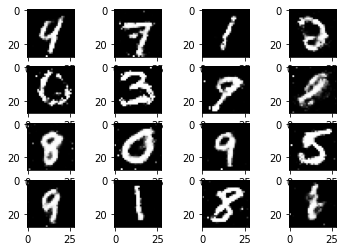

In [57]:
num_test_samples = 16
test_noise_new = Variable(torch.randn(num_test_samples, 100)).cuda()
with torch.no_grad():
        gen_images = generator(test_noise_new).cpu()
        for k in range(num_test_samples):
                    plt.subplot(4, 4, k + 1)
                    plt.imshow(gen_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys_r')
        plt.savefig('test.png'.format(epoch))
        plt.show()